# Telegram Analyse (Master-Thesis)

Informatik Master

Maximilian Bundscherer

Beschreibung tbd.

## Umgebung starten und Konfigurationen anwenden

### Parameter mit Konfigurationen

Die Läufe lassen sich mit diesen Parametern beinflussen:

| Bezeichner | Datentyp | Beispiel | Beschreibung |
|---|---|---|---|
|``C_LOCAL``|``bool``|``True``|Setzte auf ``True``, falls eine externe Verbindung zum Kernel besteht. Setzte auf ``False``, falls im Browser gearbeitet wird. Beeinflusst Pfade Arbeitsverzeichnisse.|
|``C_SHORT_RUN``|``bool``|``False``|Setzte auf ``True``, falls ein reduzierter Lauf durchgeführt werden soll. Ver- kürzt Entwicklungszeiten lokal.|
|``C_NUMBER_SAMPLES``|``int``|``1000``|Falls ``C_SHORT_RUN`` auf ``True`` gesetzt ist gültig. Um die Entwicklungszeiten weiter zu verkürzen, kann nur auf ei- nem Teil der Datenmenge operiert wer- den.|
|``C_RESOLVE_NEW_URLS``|``bool``|``True``|Sollen YouTube-Titel und Webseiten- Titel während dieses Laufs aufgelöst werden?|
|``C_LOAD_DATASETS``|``string[]``|``["dataSet0"]``|Welche DateSets sollen geladen werden?|
|``C_LOAD_PIPELINES``|``bool``|``True``|Definiert ob die Transformers geladen werden sollen. Die Läufe berücksichtigen das, da es lange Laden kann.|
|``C_PIPELINE_DATASETS``|``string[]``|``["dataSet0"]``|Falls ``C_LOAD_PIPELINES`` auf ``True`` gesetzt ist gültig. Definiert welche DateSets Trans- formers angewendet werden.|
|``C_TIME_PLOT_FREQ``|``string``|``1D``|Definiert Zeitspanne weiter unten|
|``C_USE_CACHE_FILE``|``string``|``file.pkl``|Setzten falls neuer DataFrame-Cache erzeugt werden soll. Definiert Dateinamen|
|``C_NEW_CACHE_FILE``|``string``|``file.pkl``|Setzten falls besteher DataFrame- Cache verwendet werden soll. Defi- niert Dateinamen.|

In [ ]:
C_LOCAL                 = False

C_SHORT_RUN             = False
C_NUMBER_SAMPLES        = 1000

C_RESOLVE_NEW_URLS      = False

"""
Ava:    ["dataSet0", "dataSet1", "dataSet1a", "dataSet2"]
Htdocs: ["dataSet0", "dataSet1a", "dataSet2"]
Req:    ["dataSet0"]
"""
C_LOAD_DATASETS         = ["dataSet0"]

C_LOAD_PIPELINES        = True
C_PIPELINE_DATASETS     = ["dataSet0"]

C_TIME_PLOT_FREQ        = "1D"

"""
Please set only one value!
e.g.
# - long-run-server-28-01.pkl   (Long run, with hf, with htdocs-datasets, updated with sen-pipe-2)
# - long-run-server-07-02.pkl   (Long run, with hf, with all datasets, updated with sen-pipe-2)
# - local-run-28-01.pkl         (Short run, with hf, with htdocs-datasets, updated with sen-pipe-2)
# - test.pkl                    (Test file)
"""
C_USE_CACHE_FILE        = "long-run-server-07-02.pkl"
C_NEW_CACHE_FILE        = ""

### Bibliotheken und Abhängigkeiten laden

#### Laden von Abhängigkeiten

##### Abhänigkeiten vom Docker-Image und IO-Libs und weitere

In [ ]:
# Import default libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import os
import sys
import demjson
import requests
import networkx as nx
import warnings
from pprint import pprint
from urllib.parse import urlparse
from collections import Counter
from pathlib import Path
from lxml.html import fromstring

##### Weitere Abhänigkeiten installieren

In [ ]:
!{sys.executable} -m pip install demoji
!{sys.executable} -m pip install HanTa
!{sys.executable} -m pip install textblob-de

##### Weitere Abhängigkeiten 

In [ ]:
import demoji

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

import pyLDAvis.gensim
import pickle 
import pyLDAvis

import nltk
from nltk.util import ngrams

from wordcloud import WordCloud

import torch

from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

from HanTa import HanoverTagger as ht

from textblob_de import TextBlobDE as TextBlob

##### Stopuhr bereitstellen

In [ ]:
dictGloStopwatches = dict()

# Start timer (for reporting)
def gloStartStopwatch(key):
    print("[Stopwatch started >>" + str(key) + "<<]")
    dictGloStopwatches[key] = time.time()

# Stop timer (for reporting)
def gloStopStopwatch(key):
    endTime     = time.time()
    startTime   = dictGloStopwatches[key]
    print("[Stopwatch stopped >>" + str(key) + "<< (" + '{:5.3f}s'.format(endTime-startTime) + ")]")

#### Download von Daten

##### Transfomers

In [ ]:
dictPipelines = {}

def loadPipelines():

    if(C_LOAD_PIPELINES == False):
        print("Skip loading pipelines")
        return list()

    gloStartStopwatch("Load Pipelines")
    

    gloStartStopwatch("Load ner-xlm-Roberta")
    dictPipelines["ner-xlm-roberta"] = pipeline(
        'ner', 
        model='xlm-roberta-large-finetuned-conll03-german',
        tokenizer='xlm-roberta-large-finetuned-conll03-german'
    )
    gloStopStopwatch("Load ner-xlm-Roberta")

    gloStartStopwatch("Load ner-Bert")
    dictPipelines["ner-bert"] = pipeline(
        'ner', 
        model='fhswf/bert_de_ner',
        tokenizer='fhswf/bert_de_ner'
    )
    gloStopStopwatch("Load ner-Bert")

    gloStartStopwatch("Load sen-Bert")
    dictPipelines["sen-bert"] = pipeline(
        'sentiment-analysis', 
        model='nlptown/bert-base-multilingual-uncased-sentiment',
        tokenizer='nlptown/bert-base-multilingual-uncased-sentiment'
    )
    gloStopStopwatch("Load sen-Bert")

    gloStartStopwatch("Load text-gen-gpt2")
    dictPipelines["text-gen-gpt2"] = pipeline(
        'text-generation', 
        model='dbmdz/german-gpt2',
        tokenizer='dbmdz/german-gpt2'
    )
    gloStopStopwatch("Load text-gen-gpt2")

    gloStartStopwatch("Load text-gen-gpt2-faust")
    dictPipelines["text-gen-gpt2-faust"] = pipeline(
        'text-generation', 
        model='dbmdz/german-gpt2-faust',
        tokenizer='dbmdz/german-gpt2-faust'
    )
    gloStopStopwatch("Load text-gen-gpt2-faust")


    gloStopStopwatch("Load Pipelines")

    return dictPipelines.keys()

pipelineKeys = loadPipelines()

print()
print(str(pipelineKeys))

##### NLTK

In [ ]:
# nltk download
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

##### Demoji

In [ ]:
demoji.download_codes()

### Umgebung konfigurieren und vorbereiten

#### Konfigurationen Umgebung anwenden

##### IO Einstellungen

In [ ]:
# Hide DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("once")

# Set tokenizer parallelism 
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# matplotlib output
%matplotlib inline

# Show all columns (pandas hides columns by default)
pd.set_option('display.max_columns', None)

# Set plot style
plt.style.use('ggplot')

##### Arbeitsverzeichnis definieren

In [ ]:
# Set env vars
if(C_LOCAL == True):
    dir_var = "./work/notebooks/"
else:
    dir_var = "./"

dir_var_output = dir_var + "output/"

dir_var_cache= dir_var + "cache/"

dir_var_pandas_cache = dir_var + "cache/pandas/"

# Debug output
! echo "- Workdir -"
! ls -al $dir_var

! echo
! echo "- Outputdir -"
! ls -al $dir_var_output

! echo
! echo "- Cachedir -"
! ls -al $dir_var_cache

! echo
! echo "- Pandas -"
! ls -al $dir_var_pandas_cache

#### Globale Text-Normalisierungsfunktionen definieren

##### Handelt es sich um einen JSON formatierten String?

Unterstützt singleMode und multiMode

In [ ]:
def gloCheckIsTextJsonFormatted(text, singleMode):
    textString = str(text)
    if      (singleMode == False and textString.startswith("[") == True and textString.endswith("]") == True):
        return True
    elif    (singleMode == True and textString.startswith("{") == True and textString.endswith("}") == True):
        return True
    else:
        return False

##### Deutsche Umlaute ersetzten

In [ ]:
def gloReplaceGermanChars(inputText):

    inputText = inputText.replace("ö", "oe")
    inputText = inputText.replace("ü", "ue")
    inputText = inputText.replace("ä", "ae")

    inputText = inputText.replace("Ö", "Oe")
    inputText = inputText.replace("Ü", "Ue")
    inputText = inputText.replace("Ä", "Ae")

    inputText = inputText.replace("ß", "ss")
    
    return inputText

##### Sonderzeichen entfernen und Chat Titel normalisieren

von Text und Chat-Titel

In [ ]:
# Rm unsafe chars
def gloConvertToSafeString(text):
    text = demoji.replace(text, "")
    text = gloReplaceGermanChars(text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

# Generate unique chat name
def gloConvertToSafeChatName(chatName):
    chatName = gloConvertToSafeString(chatName)
    return chatName[:30]

##### Bereitstellen von Stop Words Datenbanken

In [ ]:
def gloGetStopWordsList(filterList):

    stopwWorldsList = []

    deWordsList = nltk.corpus.stopwords.words('german')

    enWordsList = nltk.corpus.stopwords.words('english')

    aStopwords = []
    with open(dir_var + "additionalStopwords.txt") as file:
        for line in file: 
            line = line.strip()
            if(line != ""):
                aStopwords.append(line)

    for s in filterList:
        s = gloReplaceGermanChars(s)
        stopwWorldsList.append(s)

    for s in deWordsList:
        s = gloReplaceGermanChars(s)
        stopwWorldsList.append(s)

    for s in enWordsList:
        stopwWorldsList.append(s)

    for s in aStopwords:
        s = gloReplaceGermanChars(s)
        stopwWorldsList.append(s)

    return stopwWorldsList

##### Gesamten Text vom einem Chat extrahieren

In [ ]:
# param rowID e.g. procTDSafeText
def gloGenerateTextFromChat(df, rowID):
    df = df.copy()
    df = df[df.procEvalIsValidText == True]
    
    # Iterate over text (global text from group)
    textList = []
    for index, row in df.iterrows():
        textList.append(" " + row[rowID])
        
    textString = ''.join(textList)

    return textString

##### Token / Lemma / POS

In [ ]:
# TODO: https://github.com/wartaal/HanTa/blob/master/Demo.ipynb
hanoverTagger = ht.HanoverTagger('morphmodel_ger.pgz')

def getTokenFromText(inputText):
    return nltk.word_tokenize(inputText, language="german")

def getLemmaAndTaggingFromText(inputText):
    return hanoverTagger.tag_sent(getTokenFromText(inputText))

##### Freq Nouns

In [ ]:
# param outputFilename, if "" - no output
def plotFreqNouns(inputText, outputFilename, mostCommon, flagRemoveStopwords):
    # https://textmining.wp.hs-hannover.de/Preprocessing.html
    nouns = []
    sentences_tok = [nltk.tokenize.word_tokenize(sent) for sent in getTokenFromText(inputText)]

    for sent in sentences_tok:
        tags = hanoverTagger.tag_sent(sent) 
        nouns_from_sent = [lemma for (word,lemma,pos) in tags if pos == "NN" or pos == "NE"]
        nouns.extend(nouns_from_sent)

    pNouns = list()

    if(flagRemoveStopwords):

        print("- Warn: remove stopWords")
        stopWords = gloGetStopWordsList(filterList = list())
        for n in nouns:
            if n.lower() not in stopWords:
                pNouns.append(n)

    else:
        pNouns = nouns

    # Thank you https://stackoverflow.com/questions/52908305/how-to-save-a-nltk-freqdist-plot
    fig = plt.figure(figsize = (16,9))
    plt.gcf().subplots_adjust(bottom=0.15)

    fdist = nltk.FreqDist(pNouns)    

    fdist.plot(mostCommon,cumulative=False)

    _ = plt.show()

    if(outputFilename != ""):
        fig.savefig(dir_var_output + outputFilename, bbox_inches="tight")

#### Datei Cache vorbereiten

##### Cache-IO Funktionen

- toFile
- fromFile
- initFile

In [ ]:
# Dict File Cache
dictFileCache = {}

# Write dict to file (CSV)
def gloWriteDictToFile(filename, targetDict):
    dictFileCache = {} #Clear cache
    d = pd.DataFrame.from_dict(targetDict, orient="index")
    d.to_csv(dir_var_cache + filename, header=False)

# Read dict from file (CSV)
def gloReadDictFromFile(filename):
    # Cache?
    if(filename in dictFileCache):
        return dictFileCache[filename]

    d = pd.read_csv(dir_var_cache + filename, header=None, index_col=0, squeeze=True)
    retDict = d.to_dict()

    dictFileCache[filename] = retDict #Add to cache

    return retDict

# Init csv file if not exists
def gloInitFileDict(filename):
    f = Path(dir_var_cache + filename)
    if(f.exists() == False):
        print("Init cache file >>" + filename + "<<")
        f.touch()
        gloWriteDictToFile(filename, {"initKey": "initValue"})
    else:
        print("Cache already exists >>" + filename + "<<")

##### Cache Funktionen

- checkIsCached
- addToCache
- getFromCache

In [ ]:
# Check if is already cached
def gloCheckIsAlreadyCached(filename, targetKey):
    targetDict = gloReadDictFromFile(filename)
    if(targetKey in targetDict.keys()):
        return True
    else:
        return False

# Add key to cache
def gloAddToCache(filename, targetKey, targetValue):
    targetDict = gloReadDictFromFile(filename)
    targetDict[targetKey] = targetValue
    gloWriteDictToFile(filename, targetDict)

# Get key from cache
def gloGetCached(filename, targetKey):
    targetDict = gloReadDictFromFile(filename)
    return targetDict[targetKey]

##### Cache-IO init

In [ ]:
gloInitFileDict("resolved-urls.csv")
gloInitFileDict("resolved-youtube.csv")

## Einführende Beispiele

Beispielstext definieren

In [55]:
sampleText = "Ich denke an Eis in München. Das ist ein guter Beispielstext aus München. An diesem tollen Text werde ich nun einige Verfahren anwenden! Ich wohne in der Nähe von München und esse gerne Eis."
sampleText

'Ich denke an Eis in München. Das ist ein guter Beispielstext aus München. An diesem tollen Text werde ich nun einige Verfahren anwenden! Ich wohne in der Nähe von München und esse gerne Eis.'

### Token
NLTK German Token

In [56]:
list(getTokenFromText(sampleText))[:10]

['Ich', 'denke', 'an', 'Eis', 'in', 'München', '.', 'Das', 'ist', 'ein']

### POS Versuch mit NLTK Englisch

1. NLTK German Token
2. Englische Sprache (NLTK)

In [57]:
nltk.pos_tag(getTokenFromText(sampleText))

[('Ich', 'NNP'),
 ('denke', 'VBD'),
 ('an', 'DT'),
 ('Eis', 'NNP'),
 ('in', 'IN'),
 ('München', 'NNP'),
 ('.', '.'),
 ('Das', 'NNP'),
 ('ist', 'JJ'),
 ('ein', 'NN'),
 ('guter', 'NN'),
 ('Beispielstext', 'NNP'),
 ('aus', 'NN'),
 ('München', 'NNP'),
 ('.', '.'),
 ('An', 'DT'),
 ('diesem', 'JJ'),
 ('tollen', 'NN'),
 ('Text', 'NNP'),
 ('werde', 'NN'),
 ('ich', 'NN'),
 ('nun', 'FW'),
 ('einige', 'FW'),
 ('Verfahren', 'NNP'),
 ('anwenden', 'NN'),
 ('!', '.'),
 ('Ich', 'NNP'),
 ('wohne', 'NN'),
 ('in', 'IN'),
 ('der', 'NN'),
 ('Nähe', 'NNP'),
 ('von', 'NNP'),
 ('München', 'NNP'),
 ('und', 'IN'),
 ('esse', 'FW'),
 ('gerne', 'JJ'),
 ('Eis', 'NNP'),
 ('.', '.')]

### Lemma and POS HanTa

In [58]:
getLemmaAndTaggingFromText(sampleText)

[('Ich', 'ich', 'PPER'),
 ('denke', 'denken', 'VVFIN'),
 ('an', 'an', 'APPR'),
 ('Eis', 'Eis', 'NN'),
 ('in', 'in', 'APPR'),
 ('München', 'München', 'NE'),
 ('.', '--', '$.'),
 ('Das', 'das', 'PDS'),
 ('ist', 'sein', 'VAFIN'),
 ('ein', 'ein', 'ART'),
 ('guter', 'gut', 'ADJA'),
 ('Beispielstext', 'Beispielstext', 'NN'),
 ('aus', 'aus', 'APPR'),
 ('München', 'München', 'NE'),
 ('.', '--', '$.'),
 ('An', 'an', 'APPR'),
 ('diesem', 'diesem', 'PDAT'),
 ('tollen', 'toll', 'ADJA'),
 ('Text', 'Text', 'NN'),
 ('werde', 'werden', 'VAFIN'),
 ('ich', 'ich', 'PPER'),
 ('nun', 'nun', 'ADV'),
 ('einige', 'einige', 'PIAT'),
 ('Verfahren', 'Verfahren', 'NN'),
 ('anwenden', 'anwenden', 'VVINF'),
 ('!', '--', '$.'),
 ('Ich', 'ich', 'PPER'),
 ('wohne', 'wohnen', 'VVFIN'),
 ('in', 'in', 'APPR'),
 ('der', 'der', 'ART'),
 ('Nähe', 'Nähe', 'NN'),
 ('von', 'von', 'APPR'),
 ('München', 'München', 'NE'),
 ('und', 'und', 'KON'),
 ('esse', 'essen', 'VVFIN'),
 ('gerne', 'gerne', 'ADV'),
 ('Eis', 'Eis', 'NN'),
 ('.'

### Freq Nouns

- Warn: remove stopWords


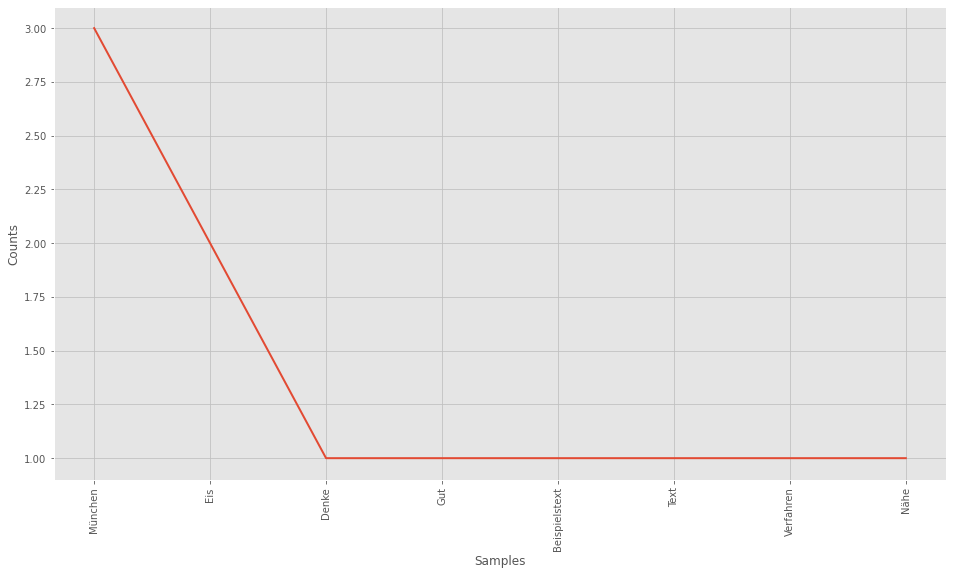

In [60]:
plotFreqNouns(sampleText, outputFilename = "", mostCommon = 10, flagRemoveStopwords = True)

## Chats laden und aufbereiten

### Stufe 1 Parsen

#### JSON Helfer

##### zu Data Frame Meta

In [74]:
# Convert to DataFrame Meta (Chat Meta)
def convertToDataFrameMeta(filePath):
    dF = pd.read_json(dir_var + "data/" + filePath + "/result.json", encoding='utf-8')
    return dF

##### zu Data Frame Messages

In [75]:
# Convert to DataFrame Messages (Chat Messages)
def convertToDataFrameMessages(filePath):
    dF = pd.json_normalize(dictMeta[filePath].messages)
    return dF

### Stufe 2 Text und Text Meta Daten Extrahieren

In [ ]:
"""
Extract text data (see cell above key)
See cell above (key)

param   procIsJsonFormatted Boolean (is text json formatted?)
param   text                String  (text from message) 

return
a   procText            Plain Text
b   processedURLs       Array of URLs in Text
c   processedHashtags   Array of Hashtags in Text #TODO: RM
d   processedBolds      Array of Bold Items in Text
e   processedItalics    Array of Italic Items in Text
f   processedUnderlines Array of Underlined Items in Text
g   processedEmails     Array of E-Mails in Text
"""
def extractTextData(procIsJsonFormatted, text):
    
    # 3 returns in this function...
    
    processedURLs       = list()
    processedHashtags   = list() # TODO: RM
    processedBolds      = list()
    processedItalics    = list()
    processedUnderlines = list()
    processedEmails     = list()
    
    if(procIsJsonFormatted != True):
        #Is not JSON formatted (return normal text)
        return (text, processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)
    else:
        #Is is JSON formatted (try to parse)
        try:
            returnList = []
            jsonList = demjson.decode(str(text), encoding='utf8')

            # Do for each item in list
            for lItem in jsonList:

                messageString = str(lItem)

                isJsonSubString = gloCheckIsTextJsonFormatted(messageString, singleMode = True)

                if(isJsonSubString):
                    # Is Json Sub String
                    subJsonString = demjson.decode(str(messageString), encoding='utf8')
                    subJsonType = subJsonString["type"]

                    if(subJsonType == "bold"):
                        #text included
                        processedBolds.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "italic"):
                        #text included
                        processedItalics.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "underline"):
                        #text included
                        processedUnderlines.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                    
                    elif(subJsonType == "email"):
                        #text included
                        processedEmails.append(subJsonString["text"])
                        
                    elif(subJsonType == "text_link"):
                        #text and href included
                        processedURLs.append(subJsonString["href"])
                        #returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "link"):
                        #text included
                        processedURLs.append(subJsonString["text"])
                        
                    elif(subJsonType == "hashtag"):
                        #text included
                        #processedHashtags.append(subJsonString["text"]) # TODO: Refactor: Dont add hashtags here!
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "mention"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "mention_name"):
                        #text and user_id included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "bot_command"):
                        #text included
                        returnList = returnList 
                        
                    elif(subJsonType == "code"):
                        #text included
                        returnList = returnList
                        
                    elif(subJsonType == "phone"):
                        #text included
                        returnList = returnList
                        
                    elif(subJsonType == "strikethrough"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "pre"):
                        #text and language included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "bank_card"):
                        #text included
                        returnList = returnList
                        
                    else:
                        print("- Error: Unkown json type >>" + str(subJsonType) + "<< (ignore) >>" + str(text) + "<<")

                else:
                    # Is no json formatted sub string (append text)
                    returnList.append(messageString)

            return (''.join(returnList), processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)
        
        except:
            # Parser error (set inputText to returnText)
            print("- Warn: Json parser error (set inputText to returnText) >>" + str(text) + "<<")
            return (text, processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)

#### Text und Text Meta Daten Extrahieren (Stufe 2)

#### Werkzeuge definieren

##### Url

- getUrlRegex
- extractUrls
- removeUrls

In [76]:
# https://stackoverflow.com/questions/6718633/python-regular-expression-again-match-url
def getUrlRegex():
    return "((?:https?://)?(?:(?:www\.)?(?:[\da-z\.-]+)\.(?:[a-z]{2,6})|(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)|(?:(?:[0-9a-fA-F]{1,4}:){7,7}[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,7}:|(?:[0-9a-fA-F]{1,4}:){1,6}:[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,5}(?::[0-9a-fA-F]{1,4}){1,2}|(?:[0-9a-fA-F]{1,4}:){1,4}(?::[0-9a-fA-F]{1,4}){1,3}|(?:[0-9a-fA-F]{1,4}:){1,3}(?::[0-9a-fA-F]{1,4}){1,4}|(?:[0-9a-fA-F]{1,4}:){1,2}(?::[0-9a-fA-F]{1,4}){1,5}|[0-9a-fA-F]{1,4}:(?:(?::[0-9a-fA-F]{1,4}){1,6})|:(?:(?::[0-9a-fA-F]{1,4}){1,7}|:)|fe80:(?::[0-9a-fA-F]{0,4}){0,4}%[0-9a-zA-Z]{1,}|::(?:ffff(?::0{1,4}){0,1}:){0,1}(?:(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])|(?:[0-9a-fA-F]{1,4}:){1,4}:(?:(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])))(?::[0-9]{1,4}|[1-5][0-9]{4}|6[0-4][0-9]{3}|65[0-4][0-9]{2}|655[0-2][0-9]|6553[0-5])?(?:/[\w\.-]*)*/?)"

def urlExtractUrls(inputText):
    return re.findall(getUrlRegex(), str(inputText))

def urlRemoveUrls(inputText):
    return re.sub(getUrlRegex(), " ", str(inputText))

##### Hashtags

- getHashtagRegex
- extractHashTags

In [77]:
def getHashtagRegex():
    return "#(\w+)"

def hashTagExtractHashTags(inputText):

    inputText = str(inputText)

    inputText = re.sub('\n', ' ', inputText) # Replace \n
    inputText = demoji.replace(inputText, " ") # Rm emoji
    inputText = gloReplaceGermanChars(inputText) # Replace german chars

    return re.findall(getHashtagRegex(), inputText)

In [ ]:
"""
Get params from extractedTextData
See cell below (key)
"""
def getExtractedTextDataParam(key, extractedTextData):

    a,b,c,d,e,f,g = extractedTextData

    if(key == 0):

        return urlRemoveUrls(a)

    elif(key == 1):

        before = b
        extracted = urlExtractUrls(a)

        after = before
        after.extend(extracted)

        """
        if(str(extracted) != "[]"):
            # TODO: Fix return bug
            print("Debug >>" + str(before) + "/" + str(extracted) + ">>" + str(after) + "<<")
        """

        return after

    elif(key == 2):

        # TODO: Refactor dont take it from extractedTextData
        return hashTagExtractHashTags(a)

    else:
        switcher = {
            3: d,
            4: e,
            5: f,
            6: g
        }
        return switcher.get(key)

#### Text und Text Meta Daten Extrahieren (Stufe 3)

In [ ]:
# returns dict (empty dict if disabled, dict with not entries if error)
listUnknownTypes = list()
def processNerPipeline(inputText, pipelineKey, configMinScore):
    if(pipelineKey in pipelineKeys):

        listPer     = list()
        listMisc    = list()
        listOrg     = list()
        listLoc     = list()


        try:

            data = dictPipelines[pipelineKey](inputText)

            for d in data:

                jsonData = demjson.decode(str(d), encoding='utf8')
                            
                if(jsonData["score"] >= configMinScore):
                    # Is Valid
                    if      (jsonData["entity"] == "I-PER" or jsonData["entity"] == "B-PER"):
                        listPer.append(jsonData["word"])
                    elif    (jsonData["entity"] == "I-MISC" or jsonData["entity"] == "B-MISC"):
                        listMisc.append(jsonData["word"])
                    elif    (jsonData["entity"] == "I-ORG" or jsonData["entity"] == "B-ORG"):
                        listOrg.append(jsonData["word"])
                    elif    (jsonData["entity"] == "I-LOC" or jsonData["entity"] == "B-LOC"):
                        listLoc.append(jsonData["word"])
                    else:
                        uT = str(jsonData["entity"])
                        if(uT not in listUnknownTypes):
                            print("- Warn - Got unknown type >>" + uT + "<<")
                            listUnknownTypes.append(uT)

        except:
            pass
            #print("Error in processNerPipeline (ignore) >>" + str(inputText) + "<<")
        

        return {
            "per": listPer,
            "misc": listMisc,
            "org": listOrg,
            "loc": listLoc
        }

    else:
        return dict()

In [ ]:
# returns
# 1 - 5 (1 = bad / 5 = good)
# -1 disabled or error
def processSenPipeline(inputText, pipelineKey, configMinScore):
    if(pipelineKey in pipelineKeys):

        sen = -1

        try:

            data = dictPipelines[pipelineKey](inputText)
            
            for d in data:


                jsonData = demjson.decode(str(d), encoding='utf-8')

                if(jsonData["score"]) > configMinScore:
                    # Is Valid
                    labelData = str(jsonData["label"])

                    if("stars" in labelData):
                        labelData = re.sub(" stars", "", labelData)
                    else:
                        labelData = re.sub(" star", "", labelData)
                    
                    sen = int(labelData)

        except:
            pass
            #print("Error in processSenPipeline (ignore) >>" + str(inputText) + "<<")

        return sen

    else:
        return -1

In [ ]:
# returns
# dict (polarity, subjectivity) or none (fail or disabled)
def processSentimentAnalysisPython(inputText):

    try:
        t = TextBlob(inputText)
        return {
            "polarity": t.polarity,
            "subjectivity": t.subjectivity
        }
    except:
        return None

In [ ]:
def evalIsValidText(procTDTextLength):
    if(procTDTextLength > 0):
        return True
    else:
        return False

In [ ]:
def evalContainsSomething(att):
    if(str(att) == "nan"):
        return False
    else:
        return True

In [ ]:
def evalNonEmptyList(att):
    if(str(att) == "[]"):
        return False
    else:
        return True

### Chats einlesen, filtern und in DataFrame laden
Ab hier Stopuhr global

In [68]:
gloStartStopwatch("Global notebook")

[Stopwatch started >>Global notebook<<]


#### Aus CSV Datei in DataFrame laden

In [66]:
# Read jobs from file
dfInputFiles = pd.read_csv(dir_var + "inputFiles.csv", sep=";")

#### Daten filtern

In [64]:
dfFilter = pd.DataFrame()

for dS in C_LOAD_DATASETS:
    dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputDesc == dS])

dfInputFiles = dfFilter

dfInputFiles

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,inputName,inputPath,inputType,inputId,inputDesc,inputDownloadType
47,ATTILA HILDMANN,DS-05-01-2021/ChatExport_2021-01-05-hildmann,public_channel,10034163583,dataSet0,onlyText
48,Oliver Janich oeffentlich,DS-05-01-2021/ChatExport_2021-01-05-janich,public_channel,9808932799,dataSet0,onlyText
49,Eva Herman Offiziell,DS-05-01-2021/ChatExport_2021-01-05-evaherman,public_channel,9915108907,dataSet0,onlyText
50,Xavier Naidoo (inoffiziell),DS-05-01-2021/ChatExport_2021-01-05-xavier,public_channel,9874390332,dataSet0,onlyText


In [ ]:
dictMeta          = {}   

# Add Key = filePath / Value = DataFrame (Chat Meta)
for fP in dfInputFiles.inputPath:
    dictMeta[fP] = convertToDataFrameMeta(fP)

In [ ]:
# return dictMessages and dfAllDataMessages
def initProcessData():

    dictMessages      = {}
    dfAllDataMessages = pd.DataFrame()

    gloStartStopwatch("Extract Text Data")

    # Add Key = filePath / Value = DataFrame (Chat Message)
    for fP in dfInputFiles.inputPath:

        gloStartStopwatch("TD-Extract " + fP)
        dfMessages                          = convertToDataFrameMessages(fP)
        tmpMeta                             = convertToDataFrameMeta(fP)

        # Short run
        if(C_SHORT_RUN):
            print("Short run active!")
            dfMessages = dfMessages.head(C_NUMBER_SAMPLES)

        # Get chat attributes and check if message is json formatted
        dfMessages["procChatFilePath"]      = fP
        dfMessages["procChatType"]          = tmpMeta.type.iloc[0]
        dfMessages["procIsJsonFormatted"]   = dfMessages["text"].apply(gloCheckIsTextJsonFormatted, singleMode = False)
        
        # Extract Text Data
        dfMessages["tmpExtractedTD"]        = dfMessages.apply(lambda x: extractTextData(x.procIsJsonFormatted, x.text), axis=1)

        # Extract Text Data (params)
        dfMessages["procTDText"]            = dfMessages.apply(lambda x: getExtractedTextDataParam(0, x.tmpExtractedTD), axis=1)
        dfMessages["procTDURLs"]            = dfMessages.apply(lambda x: getExtractedTextDataParam(1, x.tmpExtractedTD), axis=1)
        dfMessages["procTDHashtags"]        = dfMessages.apply(lambda x: getExtractedTextDataParam(2, x.tmpExtractedTD), axis=1)
        dfMessages["procTDBolds"]           = dfMessages.apply(lambda x: getExtractedTextDataParam(3, x.tmpExtractedTD), axis=1)
        dfMessages["procTDItalics"]         = dfMessages.apply(lambda x: getExtractedTextDataParam(4, x.tmpExtractedTD), axis=1)
        dfMessages["procTDUnderlines"]      = dfMessages.apply(lambda x: getExtractedTextDataParam(5, x.tmpExtractedTD), axis=1)
        dfMessages["procTDEmails"]          = dfMessages.apply(lambda x: getExtractedTextDataParam(6, x.tmpExtractedTD), axis=1)

        # Process text again
        dfMessages['procTDCleanText']           = dfMessages['procTDText'].map(lambda x: re.sub('\n', ' ', x)) # Replace \n
        dfMessages['procTDEmojis']              = dfMessages['procTDCleanText'].map(lambda x: demoji.findall_list(x, desc = False)) # Filter out emoji
        dfMessages['procTDEmojisDesc']          = dfMessages['procTDCleanText'].map(lambda x: demoji.findall_list(x, desc = True)) # Filter out emoji with desc
        dfMessages['procTDCleanText']           = dfMessages['procTDCleanText'].map(lambda x: demoji.replace(x, " ")) # Rm emoji
        dfMessages['procTDCleanText']           = dfMessages['procTDCleanText'].map(lambda x: gloReplaceGermanChars(x)) # Replace german chars
        dfMessages['procTDSafeText']            = dfMessages['procTDCleanText'].map(lambda x: re.sub(r'[^a-zA-Z0-9\s]', ' ', x)) # Filter out . ! ? ... (get only safe chars)
        dfMessages['procTDSafeLowercaseText']   = dfMessages['procTDSafeText'].map(lambda x: x.lower()) # To lower

        # Calc text size
        dfMessages["procTDTextLength"]      = dfMessages["procTDCleanText"].str.len()

        # Add columns (if not exists)
        if "photo" not in dfMessages:
            print("- Debug: Add column >>photo<<")
            dfMessages["photo"] = np.nan

        if "file" not in dfMessages:
            print("- Debug: Add column >>file<<")
            dfMessages["file"] = np.nan

        if "edited" not in dfMessages:
            print("- Debug: Add column >>edited<<")
            dfMessages["edited"] = np.nan

        if "forwarded_from" not in dfMessages:
            print("- Debug: Add column >>forwarded_from<<")
            dfMessages["forwarded_from"] = np.nan

        # Evaluate attributes
        dfMessages["procEvalIsValidText"]   = dfMessages.procTDTextLength.apply(evalIsValidText)

        dfMessages["procEvalContainsPhoto"] = dfMessages.photo.apply(evalContainsSomething)
        dfMessages["procEvalContainsFile"]  = dfMessages.file.apply(evalContainsSomething) 
        dfMessages["procEvalIsEdited"]      = dfMessages.edited.apply(evalContainsSomething)
        dfMessages["procEvalIsForwarded"]   = dfMessages.forwarded_from.apply(evalContainsSomething)
        
        dfMessages["procEvalContainsUrl"]              = dfMessages.procTDURLs.apply(evalNonEmptyList)
        dfMessages["procEvalContainsHashtag"]          = dfMessages.procTDHashtags.apply(evalNonEmptyList)
        dfMessages["procEvalContainsBoldItem"]         = dfMessages.procTDBolds.apply(evalNonEmptyList)
        dfMessages["procEvalContainsItalicItem"]       = dfMessages.procTDItalics.apply(evalNonEmptyList)
        dfMessages["procEvalContainsUnderlineItem"]    = dfMessages.procTDUnderlines.apply(evalNonEmptyList)
        dfMessages["procEvalContainsEmailItem"]        = dfMessages.procTDEmails.apply(evalNonEmptyList)
        dfMessages['procEvalContainsEmojiItem']        = dfMessages.procTDEmojis.apply(evalNonEmptyList)

        # Pipelines
        if dfInputFiles[dfInputFiles.inputPath == fP].iloc[0].inputDesc in C_PIPELINE_DATASETS:
            gloStartStopwatch("Process pipeline ner-xlm-roberta")
            dfMessages['procPipeline-ner-xlm-roberta']    = dfMessages['procTDCleanText'].map(lambda x: processNerPipeline(x, "ner-xlm-roberta", configMinScore=0))
            gloStopStopwatch("Process pipeline ner-xlm-roberta")

            gloStartStopwatch("Process pipeline ner-bert")
            dfMessages['procPipeline-ner-bert']           = dfMessages['procTDCleanText'].map(lambda x: processNerPipeline(x, "ner-bert", configMinScore=0))
            gloStopStopwatch("Process pipeline ner-bert")

            gloStartStopwatch("Process pipeline sen-bert")
            dfMessages['procPipeline-sen-bert']           = dfMessages['procTDCleanText'].map(lambda x: processSenPipeline(x, "sen-bert", configMinScore=0))
            gloStopStopwatch("Process pipeline sen-bert")

        # Sentiment Analysis
        dfMessages['procPipeline-sentiment']           = dfMessages['procTDCleanText'].map(lambda x: processSentimentAnalysisPython(x))

        # Add to dict    
        dictMessages[fP] = dfMessages
        gloStopStopwatch("TD-Extract " + fP)

    gloStopStopwatch("Extract Text Data")

    # All Messages to DataFrame
    gloStartStopwatch("Generate global DataFrame")
    for fP in dfInputFiles.inputPath:
        dfMessages        = dictMessages[fP].copy()
        dfAllDataMessages = dfAllDataMessages.append(dfMessages)
    gloStopStopwatch("Generate global DataFrame")

    return (dictMessages, dfAllDataMessages)

In [ ]:
# return dictMessages and dfAllDataMessages
def initCacheData(dfAllDataMessages):
    dictMessages = {}
    for fP in dfInputFiles.inputPath:
        dictMessages[fP] = dfAllDataMessages[dfAllDataMessages.procChatFilePath == fP]
    return (dictMessages, dfAllDataMessages)

In [ ]:
if(C_USE_CACHE_FILE == ""):
    print("Should not use cache (build new cache)")
    dictMessages, dfAllDataMessages = initProcessData()
    if(C_NEW_CACHE_FILE != ""):
        print("Write cache to file >>" + str(C_NEW_CACHE_FILE) + "<<")
        dfAllDataMessages.to_pickle(dir_var_pandas_cache + C_NEW_CACHE_FILE)
else:
    print("Should use cache (load cache)")
    dictMessages, dfAllDataMessages = initCacheData(pd.read_pickle(dir_var_pandas_cache + C_USE_CACHE_FILE))

## Meta-Queries

### Type of channels

In [ ]:
dfInputFiles.inputType.value_counts()

### Define queries

In [ ]:
def queryChatId(filePath):
    dfMeta = dictMeta[filePath].copy()
    return str(dfMeta["id"].iloc[0])

In [ ]:
def queryChatName(filePath):
    dfMeta      = dictMeta[filePath].copy()
    chatName    = str(dfMeta["name"].iloc[0])
    chatName    = gloConvertToSafeChatName(chatName)
    return chatName

In [ ]:
def queryChatType(filePath):
    dfMeta = dictMeta[filePath].copy()
    return str(dfMeta["type"].iloc[0])

In [ ]:
def queryNumberOfMessages(filePath):
    dfMessages = dictMessages[filePath].copy()
    return len(dfMessages.index)

In [ ]:
def queryNumberOfMessagesByAttEqTrue(filePath, attKey):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages[attKey] == True]
    return len(dfMessages.index)

### Execute queries

In [ ]:
dfQueryMeta = pd.DataFrame(dfInputFiles.inputPath)

dfQueryMeta["qryChatId"]                        = dfQueryMeta.inputPath.apply(queryChatId)
dfQueryMeta["qryChatName"]                      = dfQueryMeta.inputPath.apply(queryChatName)
dfQueryMeta["qryChatType"]                      = dfQueryMeta.inputPath.apply(queryChatType)
dfQueryMeta["qryNumberOfMessages"]              = dfQueryMeta.inputPath.apply(queryNumberOfMessages)

dfQueryMeta["qryNumberOfFormattedTextMessages"] = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procIsJsonFormatted"), axis=1)

dfQueryMeta["qryNumberOfValidTextMessages"]     = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalIsValidText"), axis=1)

dfQueryMeta["qryNumberOfPhotos"]                = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsPhoto"), axis=1)
dfQueryMeta["qryNumberOfFiles"]                 = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsFile"), axis=1)
dfQueryMeta["qryNumberOfEditedMessages"]        = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalIsEdited"), axis=1)
dfQueryMeta["qryNumberOfForwardedMessages"]     = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalIsForwarded"), axis=1)

dfQueryMeta["qryNumberOfMessagesWithUrl"]           = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsUrl"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithHashtag"]       = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsHashtag"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithBold"]          = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsBoldItem"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithItalic"]        = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsItalicItem"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithUnderline"]     = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsUnderlineItem"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithEmail"]         = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsEmailItem"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithEmoji"]         = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsEmojiItem"), axis=1)

dfQueryMeta.sort_values(by="qryNumberOfMessages", ascending=False)

### Plot meta queries

In [ ]:
# Auto label query plot
def autolabelAx(rects, ax):
    """
    Attach a text label above each bar in *rects*, displaying its height.
    Copied from https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html (22.12.2020)
    """
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [ ]:
# param inputDescFilter set "" == no filter
# param outputFilename set "" = no output
def queryMetaPlotter(inputDescFilter, configPlotWidth, configPlotHeight, configBarWidth, outputFilename):
    # Init data
    dataLabels                          = list()
    dataNumberOfMesssages               = list()
    dataNumberOfFormattedTextMessages   = list()
    dataNumberOfValidTextMessages       = list()
    dataNumberOfEditedMessages          = list()
    dataNumberOfForwardedMessages       = list()
    dataNumberOfPhotos                  = list()
    dataNumberOfFiles                   = list()
    dataNumberOfMessagesWUrl            = list()
    dataNumberOfMessagesWHashtag        = list()
    dataNumberOfMessagesWBold           = list()
    dataNumberOfMessagesWItalic         = list()
    dataNumberOfMessagesWUnderline      = list()
    dataNumberOfMessagesWEmail          = list()
    dataNumberOfMessagesWEmoji          = list()

    # Iterate over Meta DataFrame
    for index, row in dfQueryMeta.sort_values(by="qryNumberOfMessages", ascending=False).iterrows():

        # Get attributes (check filter)
        if(inputDescFilter == "" or dfInputFiles[dfInputFiles.inputPath == row.inputPath].inputDesc.iloc[0] == inputDescFilter):
            dataLabels                          .append(row.qryChatName)
            dataNumberOfMesssages               .append(row.qryNumberOfMessages)
            dataNumberOfFormattedTextMessages   .append(row.qryNumberOfFormattedTextMessages)
            dataNumberOfValidTextMessages       .append(row.qryNumberOfValidTextMessages)
            dataNumberOfEditedMessages          .append(row.qryNumberOfEditedMessages)
            dataNumberOfForwardedMessages       .append(row.qryNumberOfForwardedMessages)
            dataNumberOfPhotos                  .append(row.qryNumberOfPhotos)
            dataNumberOfFiles                   .append(row.qryNumberOfFiles)
            dataNumberOfMessagesWUrl            .append(row.qryNumberOfMessagesWithUrl)
            dataNumberOfMessagesWHashtag        .append(row.qryNumberOfMessagesWithHashtag)
            dataNumberOfMessagesWBold           .append(row.qryNumberOfMessagesWithBold)
            dataNumberOfMessagesWItalic         .append(row.qryNumberOfMessagesWithItalic)
            dataNumberOfMessagesWUnderline      .append(row.qryNumberOfMessagesWithUnderline)
            dataNumberOfMessagesWEmail          .append(row.qryNumberOfMessagesWithEmail)
            dataNumberOfMessagesWEmoji          .append(row.qryNumberOfMessagesWithEmoji)

    # Convert list to array
    dataLabels                          = np.array(dataLabels)
    dataNumberOfMesssages               = np.array(dataNumberOfMesssages)
    dataNumberOfFormattedTextMessages   = np.array(dataNumberOfFormattedTextMessages)
    dataNumberOfValidTextMessages       = np.array(dataNumberOfValidTextMessages)
    dataNumberOfEditedMessages          = np.array(dataNumberOfEditedMessages)
    dataNumberOfForwardedMessages       = np.array(dataNumberOfForwardedMessages)
    dataNumberOfPhotos                  = np.array(dataNumberOfPhotos)
    dataNumberOfFiles                   = np.array(dataNumberOfFiles)
    dataNumberOfMessagesWUrl            = np.array(dataNumberOfMessagesWUrl)
    dataNumberOfMessagesWHashtag        = np.array(dataNumberOfMessagesWHashtag)
    dataNumberOfMessagesWBold           = np.array(dataNumberOfMessagesWBold)
    dataNumberOfMessagesWItalic         = np.array(dataNumberOfMessagesWItalic)
    dataNumberOfMessagesWUnderline      = np.array(dataNumberOfMessagesWUnderline)
    dataNumberOfMessagesWEmail          = np.array(dataNumberOfMessagesWEmail)
    dataNumberOfMessagesWEmoji          = np.array(dataNumberOfMessagesWEmoji)

    # Draw
    with sns.color_palette("tab10", 11):
        fig, ax = plt.subplots()
    x = np.arange(len(dataLabels))

    barWidth = configBarWidth

    fig.set_figwidth(configPlotWidth)
    fig.set_figheight(configPlotHeight)

    r1 = x
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]
    r5 = [x + barWidth for x in r4]
    r6 = [x + barWidth for x in r5]
    r7 = [x + barWidth for x in r6]
    r8 = [x + barWidth for x in r7]
    r9 = [x + barWidth for x in r8]
    r10 = [x + barWidth for x in r9]
    r11 = [x + barWidth for x in r10]
    r12 = [x + barWidth for x in r11]
    r13 = [x + barWidth for x in r12]
    r14 = [x + barWidth for x in r13]

    rects1 = ax.bar(r1, dataNumberOfMesssages, barWidth, label='Messages')
    rects2 = ax.bar(r2, dataNumberOfFormattedTextMessages, barWidth, label='Formatted Messsages')
    rects3 = ax.bar(r3, dataNumberOfValidTextMessages, barWidth, label='Valid Text Messages')
    rects4 = ax.bar(r4, dataNumberOfEditedMessages, barWidth, label='Edited Messages')
    rects5 = ax.bar(r5, dataNumberOfForwardedMessages, barWidth, label='Forwarded Messages')
    rects6 = ax.bar(r6, dataNumberOfPhotos, barWidth, label='with Photo')
    rects7 = ax.bar(r7, dataNumberOfFiles, barWidth, label='with File')
    rects8 = ax.bar(r8, dataNumberOfMessagesWUrl, barWidth, label='with Url')
    rects9 = ax.bar(r9, dataNumberOfMessagesWHashtag, barWidth, label='with Hashtag')
    rects10 = ax.bar(r10, dataNumberOfMessagesWBold, barWidth, label='with Bold Items')
    rects11 = ax.bar(r11, dataNumberOfMessagesWItalic, barWidth, label='with Italic Items')
    rects12 = ax.bar(r12, dataNumberOfMessagesWUnderline, barWidth, label='with Underlined Items')
    rects13 = ax.bar(r13, dataNumberOfMessagesWEmail, barWidth, label='with E-Mails')
    rects14 = ax.bar(r14, dataNumberOfMessagesWEmoji, barWidth, label='with Emojis')

    chartTitle = ""
    if(inputDescFilter != ""):
        chartTitle = " (" + inputDescFilter + ")"

    ax.set_ylabel("Number of")
    ax.set_title("Meta Overview" + chartTitle)
    ax.set_xticks(x)
    ax.set_xticklabels(dataLabels)
    ax.legend()

    rects = [rects1, rects2, rects3, rects4, rects5, rects6, rects7, rects8, rects9, rects10, rects11, rects12, rects13, rects14]

    for rect in rects:
        autolabelAx(rect, ax)

    fig.tight_layout()

    #plt.xticks(rotation=30)
    
    if(outputFilename != ""):
        plt.savefig(dir_var_output + outputFilename)
    
    plt.show()

In [ ]:
queryMetaPlotter(
    inputDescFilter = "dataSet0",
    configPlotWidth = 32,
    configPlotHeight = 9,
    configBarWidth = 0.065,
    outputFilename = "meta-overview-dataSet0.svg"
)

In [ ]:
if("dataSet1" in C_LOAD_DATASETS):
    queryMetaPlotter(
        inputDescFilter = "dataSet1",
        configPlotWidth = 100,
        configPlotHeight = 9,
        configBarWidth = 0.065,
        outputFilename = "meta-overview-dataSet1.svg"
    )

In [ ]:
if("dataSet1a" in C_LOAD_DATASETS):
    queryMetaPlotter(
        inputDescFilter = "dataSet1a",
        configPlotWidth = 16,
        configPlotHeight = 9,
        configBarWidth = 0.065,
        outputFilename = "meta-overview-dataSet1a.svg"
    )

In [ ]:
if("dataSet2" in C_LOAD_DATASETS):
    queryMetaPlotter(
        inputDescFilter = "dataSet2",
        configPlotWidth = 34,
        configPlotHeight = 9,
        configBarWidth = 0.065,
        outputFilename = "meta-overview-dataSet2.svg"
    )

### Get text-length

In [ ]:
def removeTextLengthOutliersFromDataFrame(df, interval, maxTextLength):
    df = df.copy()
    df = df[df.procTDTextLength < maxTextLength]
    # https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
    # keep only the ones that are within <interval> to -<interval> standard deviations in the column 'Data'.
    return df[np.abs(df.procTDTextLength-df.procTDTextLength.mean()) <= (interval*df.procTDTextLength.std())]

In [ ]:
# param outputFilename set "" == no output file
def textLengthHistPlotter(outputFilename):
    dfMessages = dfAllDataMessages.copy()
    print("Number of all messages:\t\t\t\t\t\t" + str(len(dfMessages.index)))

    dfMessages = dfMessages[dfMessages.procEvalIsValidText == True]
    print("Number of valid text messages:\t\t\t\t\t" + str(len(dfMessages.index)))

    dfMessages = removeTextLengthOutliersFromDataFrame(
        dfMessages,
        interval = 3,               #Default is 3
        maxTextLength = 999999999   #TODO: Maybe enable max text length
        )
    print("Number of valid text messages (after outliers filtering):\t" + str(len(dfMessages.index)))

    print()
    print("Text Length Hist (after outliers filtering)")
    plt.figure(figsize=(8,4.5))
    _ = dfMessages.procTDTextLength.hist(bins=40)
    plt.title('Histogram Text Length')

    if(outputFilename != ""):
        plt.savefig(dir_var_output + outputFilename)

In [ ]:
textLengthHistPlotter(outputFilename = "meta-text-length-hist.svg")

### Compare ids and labels (has chat name changed?)

In [ ]:
def compareIdsAndLabels(df):

    gloStartStopwatch("Compare ids and labels")

    dictFromTranslator  = {}
    dictActorTranslator = {}

    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    
    df = df.set_index("date")
    df = df.sort_index()

    for index, row in df.iterrows():
        
        n_from      = row["from"]
        n_from_id   = row["from_id"]

        n_from = str(n_from)
        n_from_id = str(n_from_id)

        n_actor      = row["actor"]
        n_actor_id   = row["actor_id"]

        n_actor = str(n_actor)
        n_actor_id = str(n_actor_id)

        if(str(n_from) != "nan"):
            if(n_from_id not in dictFromTranslator):
                # Add new key
                dictFromTranslator[n_from_id] = [n_from]
            else:
                # Has changed?
                oValueL = dictFromTranslator[n_from_id]
                if(n_from not in oValueL):
                    newList = oValueL.copy()
                    newList.append(n_from)
                    print("- Add changed attribute in from (prev=" + str(oValueL) + "/new=" + str(newList) + ")")
                    dictFromTranslator[n_from_id] = newList

        if(str(n_actor) != "nan"):
            if(n_actor_id not in dictActorTranslator):
                # Add new key
                dictActorTranslator[n_actor_id] = [n_actor]
            else:
                # Has changed?
                oValueL = dictActorTranslator[n_actor_id]
                if(n_actor not in oValueL):
                    newList = oValueL.copy()
                    newList.append(n_actor)
                    print("- Add changed attribute in actor (prev=" + str(oValueL) + "/new=" + str(newList) + ")")
                    dictActorTranslator[n_actor_id] = newList

    gloStopStopwatch("Compare ids and labels")

    return dictFromTranslator

In [ ]:
if(C_SHORT_RUN == False):
    compareIdsAndLabels(dfAllDataMessages)

## Extract Social Graph Data

In [ ]:
def extractImportantHashtags(df):
    dfMessages = df.copy()
    dfMessages = dfMessages[dfMessages.procEvalContainsHashtag == True]

    hashTagList = list()
    for index, row in dfMessages.iterrows():
        for hashtagItem in row["procTDHashtags"]:
            hashTagList.append(hashtagItem)

    return hashTagList

In [ ]:
# return combinations
def extractImportantEmojis(df):

    dfMessages = df.copy()
    dfMessages = dfMessages[dfMessages.procEvalContainsEmojiItem == True]

    li = dfMessages.procTDEmojisDesc.values.tolist()

    retLi = list()

    for l in li:
        aString = ""
        for e in l:
            aString = aString + ":" + e 
        retLi.append(aString)

    return retLi

In [ ]:
# param flagResolveNewUrls  Flag (see config above)

def resolveUrl(completeUrl, flagResolveNewUrls):
    
    if "bit.ly" in completeUrl:

        if(gloCheckIsAlreadyCached("resolved-urls.csv", completeUrl)):
            return gloGetCached("resolved-urls.csv", completeUrl)
        else:

            if(flagResolveNewUrls == False):
                return completeUrl

            print("(Resolve now >>" + completeUrl + "<<)")
            try:
                r = requests.get(completeUrl, timeout = 5)
                u = r.url
                gloAddToCache("resolved-urls.csv", completeUrl, u)
                return u
            except:
                print("(- Warn: Can not resolve (return completeUrl))")
                return completeUrl

    else:
        return completeUrl

In [ ]:
# Return
# a = urlList,
# b = refList
# c = hostList
def extractImportantUrls(df):
    dfMessages = df.copy()
    dfMessages = dfMessages[dfMessages.procEvalContainsUrl == True]

    hostList        = list()
    urList          = list()
    refList         = list()

    counterSucHostname = 0
    counterErrHostname = 0

    for index, row in dfMessages.iterrows():
        for urlItem in row["procTDURLs"]:
            
            urlData = urlparse(str(urlItem))

            completeUrl      = urlData.geturl()

            rUrl     = resolveUrl(completeUrl, flagResolveNewUrls=C_RESOLVE_NEW_URLS)
            rUrlData = urlparse(rUrl)
            rCompleteUrl = rUrlData.geturl()
            rCompleteHostname = rUrlData.hostname

            if(str(rCompleteHostname) != "None"):
                counterSucHostname = counterSucHostname + 1

                hostList.append(str(rCompleteHostname))

                urList.append(str(rCompleteUrl))

                if "t.me" in str(rCompleteHostname):
                    refList.append(str(rCompleteUrl))
            else:
                counterErrHostname = counterErrHostname + 1

    print("Got Hostnames (suc=" + str(counterSucHostname) + "/err=" + str(counterErrHostname) + ")")

    return (urList, refList, hostList)

In [ ]:
# param flagResolveNewUrls  Flag (see config above)
def resolveImportantYoutubeVideos(urlList, flagResolveNewUrls):

    # Thanks https://gist.github.com/rodrigoborgesdeoliveira/987683cfbfcc8d800192da1e73adc486

    ytList = list()

    for url in urlList:

        url = str(url)

        if("youtube.com" in url or "youtu.be" in url or "youtube-nocookie.com" in url):
            if(gloCheckIsAlreadyCached("resolved-youtube.csv", url)):
                ytList.append(gloGetCached("resolved-youtube.csv", url)) 
            else:

                if(flagResolveNewUrls == False):
                    print("(Disable resolve new youtube urls (return completeUrl) >>" + url + "<<)")
                    ytList.append(url)
                else:
                    print("Resolve now youtube >>" + url + "<<")
                    try:
                        r = requests.get(url, timeout = 5)
                        t = fromstring(r.content)
                        a = str(t.findtext('.//title'))
                        ytList.append(a)
                        gloAddToCache("resolved-youtube.csv", url, a)
                    except:
                        print("(- Warn: Can not resolve youtube url (return completeUrl))")
                        ytList.append(url)

    return ytList

In [ ]:
# TODO: Bug: No Hostname detected if string startsWith ! "http" in urlparse
# TODO: Check: Refs ins both directions

# Returns
# a = Counter forwardedFromList
# b = Counter refList
# c = Counter hashtagList
# d = Counter hostList
# e = Counter emojiList
# f = Counter fromList
def extractSocialGraph(filePath, debugPrint, debugPrintCount):

    dfMessages = dictMessages[filePath].copy()

    hashtagList = extractImportantHashtags(dfMessages)
    emojiList = extractImportantEmojis(dfMessages)

    urlList, refList, hostList = extractImportantUrls(dfMessages)

    ytList = resolveImportantYoutubeVideos(urlList, flagResolveNewUrls = C_RESOLVE_NEW_URLS)
            
    forwardedFromList = list()
    if("forwarded_from" in dfMessages.columns):
        df = dfMessages.copy()
        df = df[df.procEvalIsForwarded == True]
    
        for index, row in df.iterrows():        
            forwardedFromList.append(str(row["forwarded_from"]))
            
    actorList = list()
    if("actor" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            actorList.append(str(row["actor"]))
    
    memberList = list()
    if("members" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            if(str(row["members"]) != "nan"):
                for memberItem in row["members"]:
                    memberList.append(str(memberItem))
                    
    fromList = list()
    if("from" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            s = str(row["from"])
            s = gloConvertToSafeString(s)
            if(s != "None"):
                fromList.append(s)
            
    savedFromList = list()
    if("saved_from" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            savedFromList.append(str(row["saved_from"]))

    configTopN = debugPrintCount

    if(debugPrint):

        print()
        print("Set top n to " + str(debugPrintCount))
        print()

        print("- Top Hosts (resovled) -")
        print ("\n".join(map(str, Counter(hostList).most_common(configTopN))))
        print()
        print("- Top URLs (resolved) -")
        print ("\n".join(map(str, Counter(urlList).most_common(configTopN))))
        print()
        print("- Top Refs from text (resolved) -")
        print ("\n".join(map(str, Counter(refList).most_common(configTopN))))
        print()
        print("- Top Refs (forwarded_from) -")
        print ("\n".join(map(str, Counter(forwardedFromList).most_common(configTopN))))
        print()
        print("- Top Refs (actor) -")
        print ("\n".join(map(str, Counter(actorList).most_common(configTopN))))
        print()
        print("- Top Refs (members) -")
        print ("\n".join(map(str, Counter(memberList).most_common(configTopN))))
        print()
        print("- Top Refs (from) -")
        print ("\n".join(map(str, Counter(fromList).most_common(configTopN))))
        print()
        print("- Top Refs (saved_from) -")
        print ("\n".join(map(str, Counter(savedFromList).most_common(configTopN))))
        print()
        print("- Top hashtags -")
        print ("\n".join(map(str, Counter(hashtagList).most_common(configTopN))))
        print()
        print("- Top emojis -")
        print ("\n".join(map(str, Counter(emojiList).most_common(configTopN))))
        print()
        print("- Top yt (resolved) -")
        print ("\n".join(map(str, Counter(ytList).most_common(configTopN))))
        print()
    
    return (Counter(forwardedFromList), Counter(refList), Counter(hashtagList),  Counter(hostList), Counter(emojiList), Counter(fromList))

In [ ]:
def printSocialGraphDebug(filePathList):
    for fP in filePathList:
        print("Analyse now >>" + fP + "<<")
        _ = extractSocialGraph(fP, debugPrint=True, debugPrintCount=10)

In [ ]:
if(C_SHORT_RUN == False):
    printSocialGraphDebug(dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath)

In [ ]:
if(C_SHORT_RUN == False and False): # TODO: Enable - Disable (read)
    printSocialGraphDebug(dfInputFiles[dfInputFiles.inputDesc == "dataSet1a"].inputPath)

In [ ]:
if(C_SHORT_RUN == False) and False: # TODO: Enable - Disable (read)
    printSocialGraphDebug(dfInputFiles[dfInputFiles.inputDesc == "dataSet2"].inputPath)

In [ ]:
dictSGD_ForwardedFrom = {}
dictSGD_Ref           = {}
dictSGD_Hashtag       = {}
dictSGD_Host          = {}
dictSGD_Emoji         = {}
dictSGD_From          = {}

gloStartStopwatch("Extract Social Graph Data")

for fP in dfInputFiles.inputPath:

    gloStartStopwatch("Extract Social Graph Data >>" + fP + "<<")

    a, b, c, d, e, f = extractSocialGraph(fP, debugPrint=False, debugPrintCount = 0)

    dictSGD_ForwardedFrom[fP]   = a
    dictSGD_Ref[fP]             = b
    dictSGD_Hashtag[fP]         = c
    dictSGD_Host[fP]            = d
    dictSGD_Emoji[fP]           = e
    dictSGD_From[fP]            = f

    gloStopStopwatch("Extract Social Graph Data >>" + fP + "<<")

gloStopStopwatch("Extract Social Graph Data")

### Get Top Influencer (Downloaded?)

In [ ]:
# Get Top Influencer
# param fPList      filePath List
# param configTopN  Get Top n influencer e.g. 10
def getTopInfluencer(fPList, configTopN):

    for fP in fPList:

        chatName = queryChatName(fP)

        print()
        print("Analyse Chat (Forwarded From) >>" + chatName + "<<")
        
        socialGraphData = dictSGD_ForwardedFrom[fP]
        socialGraphData = socialGraphData.most_common(configTopN)

        counter = 1

        # Iterate over data
        for oChatName, oChatRefs in socialGraphData:
            
            # Query other params
            oChatName    = gloConvertToSafeChatName(str(oChatName))
            oChatRefs    = oChatRefs

            # Already downloaded?
            flagDownloaded = False
            if oChatName in dfQueryMeta.qryChatName.values:
                flagDownloaded = True

            if(oChatName != "nan"):

                print(str(counter) + ": (downloaded=" + str(flagDownloaded) + ") (refs=" + str(oChatRefs) + ")\t\t>>" + str(oChatName) + "<<")
                counter = counter + 1


        print()
        print("Analyse Chat (Refs) >>" + chatName + "<<")
        
        socialGraphData = dictSGD_Ref[fP]
        socialGraphData = socialGraphData.most_common(configTopN)

        counter = 1

        # Iterate over data
        for oChatName, oChatRefs in socialGraphData:
            
            # Query other params
            oChatName    = str(oChatName)
            oChatRefs    = oChatRefs

            if(oChatName != "nan"):

                print(str(counter) + " (refs=" + str(oChatRefs) + ")\t\t>>" + str(oChatName) + "<<")
                counter = counter + 1

In [ ]:
# TODO: Can not get all items in dataSet1

"""
# Attila Hildmann #
- Anonymous Germany - not found
- https://t.me/DEMOKRATENCHAT - no entries
- https://t.me/ChatDerFreiheit - no entries
- https://t.me/FREIHEITSCHAT2020 - not found

# Oliver Janich #
- Oliver Janich Premium - not found

# Xavier Naidoo #
- Xavier(Der VereiNiger)Naidoo😎 - not found
- https://t.me/PostAppender_bot - bot chat
"""
getTopInfluencer(list(dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath), 10)

### Plot Social Graph

In [ ]:
"""
Social Graph Layout Selector

param G Graph
param layoutSelector:

1 = Kamda Kawai Layout
2 = Spring Layout
3 = Graphviz Layout
"""
def getSocialGraphLayout(layoutSelector, G):
    if(layoutSelector == 1):
        return nx.kamada_kawai_layout(G.to_undirected())
    elif(layoutSelector == 2):
        return nx.spring_layout(G.to_undirected(), k = 0.15, iterations=200)
    elif(layoutSelector == 3):
        return nx.nx_pydot.graphviz_layout(G)

In [ ]:
# TODO: Try different arrows (see below): https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.patches.ArrowStyle.html
# TODO: Check distances between nodes

"""
Draw social grah

param   G                           graph
param   layoutSelector              see above
param   configFactorEdge            e.g. 100 => weight / 100
param   configFactorNode            e.g. 10  => weight / 10
param   configArrowSize             e.g. 5
param   configPlotWidth             e.g. 16
param   configPlotHeight            e.g. 9
param   outputFilename              e.g. test.png (set "" == no output file)
param   outputTitle                 e.g. Graph (required)
"""
def drawSocialGraph(G, layoutSelector, configFactorEdge, configFactorNode, configArrowSize, configPlotWidth, configPlotHeight, outputFilename, outputTitle):
    
    gloStartStopwatch("Social Graph Plot")
    
    plt.figure(figsize=(configPlotWidth,configPlotHeight))
        
    pos = getSocialGraphLayout(layoutSelector = layoutSelector, G = G)
    
    # Clean edges
    edges       = nx.get_edge_attributes(G, "weight")
    edgesTLabel = nx.get_edge_attributes(G, "tLabel")

    clean_edges         = dict()
    clean_edges_labels  = dict()
    
    for key in edges:
        
        #Set edge weight
        clean_edges[key]        = (100 - edges[key]) / configFactorEdge

        #set edge layout
        clean_edges_labels[key] = edgesTLabel[key]
    
    # Clean nodes
    nodes       = nx.get_node_attributes(G,'weight')
    nodesTLabel = nx.get_node_attributes(G,'tLabel')
    nodesTColor = nx.get_node_attributes(G,'tColor')

    clean_nodes         = dict()
    clean_nodes_labels  = dict()
    clean_nodes_color   = dict()
    
    for key in nodes:
        
        #Set node weight        
        clean_nodes[key]        = nodes[key] / configFactorNode

        #Set node layout
        clean_nodes_labels[key] = nodesTLabel[key]
        clean_nodes_color[key]  = nodesTColor[key]
    
    # Revert DiGraph (arrows direction)
    G_rev = nx.DiGraph.reverse(G)    

    # Draw
    nx.draw(G_rev,
        pos,
        with_labels=True,
        width=list(clean_edges.values()),
        node_size=list(clean_nodes.values()),
        labels=clean_nodes_labels,
        node_color=list(clean_nodes_color.values()),
        arrowsize=configArrowSize,
        arrowstyle="wedge"
        #connectionstyle="arc3, rad = 0.1"
    )
    
    # Set labels
    _ = nx.draw_networkx_edge_labels(G_rev, pos, edge_labels=clean_edges_labels)

    plt.title(outputTitle)

    # Save and show fig
    if(outputFilename != ""):
        plt.savefig(dir_var_output + outputFilename)
    
    plt.show()
    
    gloStopStopwatch("Social Graph Plot")

In [ ]:
# Generates Test Graph
def generateTestGraph():

    G_weighted = nx.DiGraph()

    G_weighted.add_edge("N1", "N2", weight=100-30,  tLabel = "(≙" + str(100-30) + ")")
    G_weighted.add_edge("N1", "N3", weight=100-10,  tLabel = "(≙" + str(100-10) + ")")
    G_weighted.add_edge("N1", "N4", weight=100-60,  tLabel = "(≙" + str(100-60) + ")")

    G_weighted.add_edge("N4", "N5", weight=100-80,  tLabel = "(≙" + str(100-80) + ")")
    G_weighted.add_edge("N4", "N6", weight=100-10,  tLabel = "(≙" + str(100-10) + ")")

    G_weighted.add_edge("N4", "N7", weight=100-30,   tLabel = "(≙" + str(100-30) + ")")
    G_weighted.add_edge("N7", "N4", weight=100-70,   tLabel = "(≙" + str(100-70) + ")")

    G_weighted.add_node("N1", weight=500.0, tLabel = "N1-T", tColor="red")
    G_weighted.add_node("N2", weight=500.0, tLabel = "N2-T", tColor="blue")
    G_weighted.add_node("N3", weight=500.0, tLabel = "N3-T", tColor="blue")
    G_weighted.add_node("N4", weight=500.0, tLabel = "N4-T", tColor="red")
    G_weighted.add_node("N5", weight=500.0, tLabel = "N5-T", tColor="red")
    G_weighted.add_node("N6", weight=500.0, tLabel = "N6-T", tColor="red")
    G_weighted.add_node("N7", weight=500.0, tLabel = "N7-T", tColor="blue")

    return G_weighted

In [ ]:
# Add node weight to dict
# Only adds new weight if newWeight > oldWeight
def addSocialGraphNodeWeight(chatName, chatWeight, targetDict):
    
    if(chatName in targetDict):
        oldWeight = targetDict[chatName]
        if(chatWeight > oldWeight):
            targetDict[chatName] = chatWeight
    else:
        targetDict[chatName] = chatWeight

In [ ]:
"""
Generate social graph

param   configTopNInfluencer        e.g. For top 10 = 10
param   configMinRefs               e.g. 1 must have > 1 % forwarded messages
param   listFilePaths               List process filePaths
param   socialGraphTargetDict       e.g. forwarded from dict or hashtag dict
param   socialGraphTargetAttribute  e.g. procEvalIsForwarded (for calc percent)
param   configFlagDebugLabel        e.g. show debug info on label
"""
def generateSocialGraph(configTopNInfluencer, configMinRefs, listFilePaths, socialGraphTargetDict, socialGraphTargetAttribute, configFlagDebugLabel):
    
    # Save node weights to dict
    dictSocialNodeWeights   = dict()

    # Flag downloaded nodes (exact node weight)
    dictExactNodesLabels    = {}
    
    gloStartStopwatch("Social Graph")
    
    # Generate directed graph
    G_weighted = nx.DiGraph()
    
    print("- Add edges")
    for fP in listFilePaths:
        
        # Query own params
        chatName                        = queryChatName(fP)
        chatNumberOfMessages            = queryNumberOfMessages(fP)
        chatNumberOfTargetMessages      = queryNumberOfMessagesByAttEqTrue(fP, socialGraphTargetAttribute)

        gloStartStopwatch("SG-Extract " + chatName + "(" + str(chatNumberOfTargetMessages) + "/" + str(chatNumberOfMessages) + " messages)")
        
        # Add exact node size (chat downloaded) and flag node
        addSocialGraphNodeWeight(chatName, chatNumberOfMessages, dictSocialNodeWeights)
        dictExactNodesLabels[chatName] = str(chatName) + "\n=[" + str(chatNumberOfTargetMessages) + "/" + str(chatNumberOfMessages) + "]"

        # Extract social graph data and get top influencer
        socialGraphData = socialGraphTargetDict[fP]
        socialGraphData = socialGraphData.most_common(configTopNInfluencer)
        
        # Iterate over forwarder
        for oChatName, oChatRefs in socialGraphData:
            
            # Query other params
            oChatName    = gloConvertToSafeChatName(str(oChatName))
            oChatRefs    = oChatRefs

            # If has forwarder
            if(oChatName != "nan"):
        
                # Calc percent (forwarded_messages)
                per = (oChatRefs/chatNumberOfTargetMessages) * 100

                # Filter unimportant forwarders
                if(per > configMinRefs):
                
                    # Add estimanted node size (chat not downloaded)
                    addSocialGraphNodeWeight(oChatName, oChatRefs, dictSocialNodeWeights)

                    # Invert percent (distance)
                    wei = 100 - per

                    # Label
                    if(configFlagDebugLabel):
                        lab = str(round(per, 3)) + "% (" + str(oChatRefs) + "/" + str(chatNumberOfTargetMessages) + "≙" + str(round(wei, 3)) + ")"
                    else:
                        lab = str(round(per, 3)) + "% (" + str(oChatRefs) + "/" + str(chatNumberOfTargetMessages) + ")"

                    # Add edge
                    G_weighted.add_edge(
                        chatName,
                        oChatName,
                        weight=wei,
                        tLabel = lab
                    )

        gloStopStopwatch("SG-Extract " + chatName + "(" + str(chatNumberOfTargetMessages) + "/" + str(chatNumberOfMessages) + " messages)")
        
    print("- Add different nodes")
    for aNode in dictSocialNodeWeights:
        
        # Query node params
        nodeName   = str(aNode)
        nodeWeight = dictSocialNodeWeights[aNode]

        # Set defaults
        tValueColor = "#ff8000"
        tLabel = str(nodeName) + "\n≈[" + str(nodeWeight) + "]"

        # Overwrite (if chat downloaded = exact weight)
        if(nodeName in dictExactNodesLabels):
            tValueColor = "#0080ff"
            tLabel = dictExactNodesLabels[nodeName]
        
        G_weighted.add_node(
            nodeName,
            weight=nodeWeight,
            tLabel = tLabel,
            tColor=tValueColor
        )
        
    gloStopStopwatch("Social Graph")
        
    return G_weighted

#### Test Graphs

In [ ]:
generatedTestGraph = generateTestGraph()

In [ ]:
drawSocialGraph(
    G = generatedTestGraph,
    layoutSelector=1,
    configFactorEdge = 10,
    configFactorNode = 1,
    configArrowSize = 15,
    configPlotWidth = 8,
    configPlotHeight = 4.5,
    outputFilename = "",
    outputTitle = "Test Graph Kamda Kawai Layout"
)

In [ ]:
drawSocialGraph(
    G = generatedTestGraph,
    layoutSelector=2,
    configFactorEdge = 10,
    configFactorNode = 1,
    configArrowSize = 15,
    configPlotWidth = 8,
    configPlotHeight = 4.5,
    outputFilename = "",
    outputTitle = "Test Graph Spring Layout"
)

In [ ]:
drawSocialGraph(
    G = generatedTestGraph,
    layoutSelector=3,
    configFactorEdge = 10,
    configFactorNode = 1,
    configArrowSize = 15,
    configPlotWidth = 8,
    configPlotHeight = 4.5,
    outputFilename = "",
    outputTitle = "Test Graph Graphviz Layout"
)

#### Real Graph (ForwardedFrom)

In [ ]:
drawSocialGraph(
    generateSocialGraph(
        configTopNInfluencer = 100,  
        configMinRefs = 0.5,       
        listFilePaths = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath),
        socialGraphTargetDict = dictSGD_ForwardedFrom,
        socialGraphTargetAttribute = "procEvalIsForwarded",
        configFlagDebugLabel = False
    ),
    layoutSelector = 1,
    configFactorEdge = 100,
    configFactorNode = 10,
    configArrowSize = 15,
    configPlotWidth = 32,
    configPlotHeight = 32,
    outputFilename = "social-graph-dataSet0-forwarded-from.svg",
    outputTitle = "Forwarded From (Top 100 by 0.5 percent) (dataSet0)"
)

In [ ]:
if("dataSet2" in C_LOAD_DATASETS):
    drawSocialGraph(
        generateSocialGraph(
            configTopNInfluencer = 100,  
            configMinRefs = 1,       
            listFilePaths = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet2"].inputPath),
            socialGraphTargetDict = dictSGD_ForwardedFrom,
            socialGraphTargetAttribute = "procEvalIsForwarded",
            configFlagDebugLabel = False
        ),
        layoutSelector = 1,
        configFactorEdge = 100,
        configFactorNode = 10,
        configArrowSize = 15,
        configPlotWidth = 32,
        configPlotHeight = 32,
        outputFilename = "social-graph-dataSet2-forwarded-from.svg",
        outputTitle = "Forwarded From (Top 100 by 1 percent) (dataSet2)"
    )

In [ ]:
# TODO: Enable
"""
drawSocialGraph(
    generateSocialGraph(
        configTopNInfluencer = 25,  
        configMinRefs = 0,       
        listFilePaths = list(dfInputFiles.inputPath),
        socialGraphTargetDict = dictSGD_ForwardedFrom,
        socialGraphTargetAttribute = "procEvalIsForwarded",
        configFlagDebugLabel = False
    ),
    layoutSelector = 3,
    configFactorEdge = 100,
    configFactorNode = 10,
    configArrowSize = 15,
    configPlotWidth = 32,
    configPlotHeight = 32,
    outputFilename = "social-graph-global-graphviz-forwarded-from.svg",
    outputTitle = "Forwarded From (Top 25) (global - graphviz)"
)
"""

#### Real Graph (Hashtag)

In [ ]:
drawSocialGraph(
    generateSocialGraph(
        configTopNInfluencer = 100,  
        configMinRefs = 0.5,        
        listFilePaths = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath),
        socialGraphTargetDict = dictSGD_Hashtag,
        socialGraphTargetAttribute = "procEvalContainsHashtag",
        configFlagDebugLabel = False
    ),
    layoutSelector = 1,
    configFactorEdge = 100,
    configFactorNode = 10,
    configArrowSize = 15,
    configPlotWidth = 32,
    configPlotHeight = 32,
    outputFilename = "social-graph-dataSet0-hashtag.svg",
    outputTitle = "Hashtags (Top 100 by 0.5 percent) (dataSet0)"
)

In [ ]:
if("dataSet2" in C_LOAD_DATASETS and False): #TODO: Fix Graph
    drawSocialGraph(
        generateSocialGraph(
            configTopNInfluencer = 30,  
            configMinRefs = 4,        
            listFilePaths = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet2"].inputPath),
            socialGraphTargetDict = dictSGD_Hashtag,
            socialGraphTargetAttribute = "procEvalContainsHashtag",
            configFlagDebugLabel = False
        ),
        layoutSelector = 1,
        configFactorEdge = 100,
        configFactorNode = 10,
        configArrowSize = 15,
        configPlotWidth = 32,
        configPlotHeight = 32,
        outputFilename = "social-graph-dataSet2-hashtag.svg",
        outputTitle = "Hashtags (Top 30) (dataSet2)"
    )

#### Real Graph (Hosts)

In [ ]:
drawSocialGraph(
    generateSocialGraph(
        configTopNInfluencer = 100,  
        configMinRefs = 0.5,        
        listFilePaths = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath),
        socialGraphTargetDict = dictSGD_Host,
        socialGraphTargetAttribute = "procEvalContainsUrl",
        configFlagDebugLabel = False
    ),
    layoutSelector = 1,
    configFactorEdge = 100,
    configFactorNode = 10,
    configArrowSize = 15,
    configPlotWidth = 32,
    configPlotHeight = 32,
    outputFilename = "social-graph-dataSet0-host.svg",
    outputTitle = "Hosts (Top 100 by 0.5 percent) (dataSet0)"
)

In [ ]:
if("dataSet2" in C_LOAD_DATASETS):
    drawSocialGraph(
        generateSocialGraph(
            configTopNInfluencer = 100,  
            configMinRefs = 1,        
            listFilePaths = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet2"].inputPath),
            socialGraphTargetDict = dictSGD_Host,
            socialGraphTargetAttribute = "procEvalContainsUrl",
            configFlagDebugLabel = False
        ),
        layoutSelector = 1,
        configFactorEdge = 100,
        configFactorNode = 10,
        configArrowSize = 15,
        configPlotWidth = 32,
        configPlotHeight = 32,
        outputFilename = "social-graph-dataSet2-host.svg",
        outputTitle = "Hosts (Top 100 by 1 percent) (dataSet2)"
    )

#### Real Graph (Emojis)

In [ ]:
drawSocialGraph(
    generateSocialGraph(
        configTopNInfluencer = 100,  
        configMinRefs = 0.5,        
        listFilePaths = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath),
        socialGraphTargetDict = dictSGD_Emoji,
        socialGraphTargetAttribute = "procEvalContainsEmojiItem",
        configFlagDebugLabel = False
    ),
    layoutSelector = 1,
    configFactorEdge = 100,
    configFactorNode = 10,
    configArrowSize = 15,
    configPlotWidth = 32,
    configPlotHeight = 32,
    outputFilename = "social-graph-dataSet0-emoji.svg",
    outputTitle = "Emojis (Top 100 by 0.5 percent) (dataSet0)"
)

In [ ]:
if("dataSet2" in C_LOAD_DATASETS):
    drawSocialGraph(
        generateSocialGraph(
            configTopNInfluencer = 100,  
            configMinRefs = 1,        
            listFilePaths = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet2"].inputPath),
            socialGraphTargetDict = dictSGD_Emoji,
            socialGraphTargetAttribute = "procEvalContainsEmojiItem",
            configFlagDebugLabel = False
        ),
        layoutSelector = 1,
        configFactorEdge = 100,
        configFactorNode = 10,
        configArrowSize = 15,
        configPlotWidth = 32,
        configPlotHeight = 32,
        outputFilename = "social-graph-dataSet2-emoji.svg",
        outputTitle = "Emojis (Top 100 by 1 percent) (dataSet2)"
    )

#### Real Graph (From)

In [ ]:
if("dataSet1a" in C_LOAD_DATASETS):
    drawSocialGraph(
        generateSocialGraph(
            configTopNInfluencer = 50,  
            configMinRefs = 0,        
            listFilePaths = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet1a"].inputPath),
            socialGraphTargetDict = dictSGD_From,
            socialGraphTargetAttribute = "procEvalIsValidText", #TODO: Improve
            configFlagDebugLabel = False
        ),
        layoutSelector = 1,
        configFactorEdge = 100,
        configFactorNode = 1,
        configArrowSize = 15,
        configPlotWidth = 32,
        configPlotHeight = 32,
        outputFilename = "social-graph-dataSet1a-from.svg",
        outputTitle = "From (Top 50) (dataSet1a)"
    )

In [ ]:
if("dataSet2" in C_LOAD_DATASETS):
    drawSocialGraph(
        generateSocialGraph(
            configTopNInfluencer = 50,  
            configMinRefs = 0,        
            listFilePaths = [
                "DS-13-01-2021/ChatExport_2021-01-13-querdenken089",
                "DS-13-01-2021/ChatExport_2021-01-13-querdenken69",
                "DS-13-01-2021/ChatExport_2021-01-13-querdenken773",
                "DS-13-01-2021/ChatExport_2021-01-13-querdenken711"
                ],
            socialGraphTargetDict = dictSGD_From,
            socialGraphTargetAttribute = "procEvalIsValidText", #TODO: Improve
            configFlagDebugLabel = False
        ),
        layoutSelector = 1,
        configFactorEdge = 100,
        configFactorNode = 1,
        configArrowSize = 15,
        configPlotWidth = 32,
        configPlotHeight = 32,
        outputFilename = "social-graph-groups-dataSet2-from.svg",
        outputTitle = "From (Top 50) (dataSet2-groups)"
    )

## Time Tools

In [ ]:
"""
param   targetDate      e.g. 1970-01-01
param   fP              filePath
param   highlightWord   set "" = no filter
"""
def queryNumberOfMessagesByDate(targetDate, fP, highlightWord):

    df = dictMessages[fP].copy()

    df = df[df.procEvalIsValidText == True]

    df["date"] = pd.to_datetime(df["date"])
    
    df = df[df.date <= targetDate]

    if(highlightWord != ""):
        df = df[df.procTDSafeLowercaseText.str.contains(highlightWord)]

    l = len(df.index)

    if(l > 0):
        return l
    else:
        return np.nan

In [ ]:
"""
param   filePathList
param   outputFilename  set "" = no output file
param   highlightWords  list of highlight words (leave empty if not used)
param   configFrequency e.g. 1D or 1M
"""
# TODO: Add percent to label
def drawTimePlot(filePathList, outputFilename, highlightWords, configFrequency):

    gloStartStopwatch("Time Plot")

    plt.figure(figsize=(16, 9))

    df = pd.DataFrame(
        index=pd.date_range( #m/d/y
            start='9/1/2018',
            end='2/1/2021',
            freq=configFrequency
            )
        )

    # Add date to process
    df["date"] = df.index

    vLineHeight = -1

    for fP in filePathList:
        gloStartStopwatch("Time Plot >>" + fP + "<<")

        # Plot Graph Var 1
        if not highlightWords:
            # Plot
            plt.plot(
                df.index, #x
                df.apply(lambda x: queryNumberOfMessagesByDate(x.date, fP, highlightWord = ""), axis=1), #y
                label = queryChatName(fP) #label
            )
            # Set vline height
            currentHeight = queryNumberOfMessagesByAttEqTrue(fP, "procEvalIsValidText")
            if(currentHeight > vLineHeight):
                vLineHeight = currentHeight

        # Plot High Light Word Graph / Var 2
        for hWord in highlightWords:
            y = df.apply(lambda x: queryNumberOfMessagesByDate(x.date, fP, highlightWord = hWord), axis=1)
            # Plot
            plt.plot(
                df.index, #x
                y, #y
                label = queryChatName(fP) + " usage of '" + hWord + "'" #label
            )
            # Set vline height
            currentHeight = y.max()
            if(currentHeight > vLineHeight):
                vLineHeight = currentHeight

        gloStopStopwatch("Time Plot >>" + fP + "<<")

    # yy - mm - dd
    # TODO: Double check https://www.bundesgesundheitsministerium.de/coronavirus/chronik-coronavirus.html?stand=20210104
    plt.vlines(x = ["2018-12-10"], ymin=0, ymax=vLineHeight, color="orange", ls='--', label="Global Compact for Migration (2018-12-10)")
    plt.vlines(x = ["2020-01-27"], ymin=0, ymax=vLineHeight, color="grey", ls='--', label="Corona Patient Zero Germany")
    plt.vlines(x = ["2020-03-23"], ymin=0, ymax=vLineHeight, color="purple", ls='--', label="1. Lockdown Germany (2020-03-23)")
    plt.vlines(x = ["2020-11-02"], ymin=0, ymax=vLineHeight, color="purple", ls='--', label="2. Lockdown light Germany (2020-11-02)")
    plt.vlines(x = ["2020-12-16"], ymin=0, ymax=vLineHeight, color="purple", ls='--', label="3. Lockdown Germany (2020-12-16)")

    plt.gcf().autofmt_xdate()
    _ = plt.legend()

    if(outputFilename != ""):
        plt.savefig(dir_var_output + outputFilename)

    gloStopStopwatch("Time Plot")

In [ ]:
if(C_SHORT_RUN == False):
    drawTimePlot(
        filePathList = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath),
        outputFilename = "time-plot-dataSet0.svg",
        highlightWords = [],
        configFrequency=C_TIME_PLOT_FREQ
    )

In [ ]:
if(C_SHORT_RUN == False):
    if("dataSet1" in C_LOAD_DATASETS):
        drawTimePlot(
            filePathList = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet1"].inputPath),
            outputFilename = "time-plot-dataSet1.svg",
            highlightWords = [],
            configFrequency=C_TIME_PLOT_FREQ
        )

In [ ]:
if(C_SHORT_RUN == False):
    if("dataSet1a" in C_LOAD_DATASETS):
        drawTimePlot(
            filePathList = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet1a"].inputPath),
            outputFilename = "time-plot-dataSet1a.svg",
            highlightWords = [],
            configFrequency=C_TIME_PLOT_FREQ
        )

In [ ]:
if(C_SHORT_RUN == False):
    if("dataSet2" in C_LOAD_DATASETS):
        drawTimePlot(
            filePathList = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet2"].inputPath),
            outputFilename = "time-plot-dataSet2.svg",
            highlightWords = [],
            configFrequency=C_TIME_PLOT_FREQ
        )

## Word Clouds

In [ ]:
# TODO: Context?
# TODO: Improve stop words

"""
WordCloud

param   targetDataFrame     DataFrame
param   outputFilename      filename in outputdir (set "" == no output file)
param   filterList          Exclude list
param   flagShow            Set true == show wordcloud
param   configPlotWidth     e.g. 1920
param   configPlotHeight    e.g. 1080
"""
def generateWordCloud(targetDataFrame, outputFilename, filterList, flagShow, configPlotWidth, configPlotHeight):
    

    dfMessages = targetDataFrame.copy()
    
    textString = gloGenerateTextFromChat(dfMessages, rowID="procTDSafeText")
    
    stopWordsList = gloGetStopWordsList(filterList)
    
    # Generate word cloud and save it to file
    wordcloud = WordCloud(
                background_color="black",
                width=configPlotWidth,
                height=configPlotHeight,
                stopwords=stopWordsList
            ).generate(textString)

    if(outputFilename != ""):
        wordcloud.to_file(dir_var_output + outputFilename)
    
    if(flagShow):
        # Show top 20
        print()
        print("Top 20 occ:\n" + str(pd.Series(wordcloud.words_).head(20)))
        print()
        
        # Show word cloud
        print("- Start generate figure")
        plt.figure(figsize=(14, 14))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.show()
    

### Single Mode

In [ ]:
# Oliver Janich öffentlich (public_channel - dataSet0)
generateWordCloud(
    dictMessages["DS-05-01-2021/ChatExport_2021-01-05-janich"],
    "wordcloud-oliver-janich.png",
    [],
    flagShow = True,
    configPlotWidth = 1920,
    configPlotHeight = 1080
)

In [ ]:
# ATTILA HILDMANN OFFICIAL (public_channel - dataSet0)
if(C_SHORT_RUN == False):
    generateWordCloud(
        dictMessages["DS-05-01-2021/ChatExport_2021-01-05-hildmann"],
        "wordcloud-attila-hildmann.png",
        [],
        flagShow = True,
        configPlotWidth = 1920,
        configPlotHeight = 1080
    )

In [ ]:
# Eva Herman Offiziell (public_channel - dataSet0)
if(C_SHORT_RUN == False):
    generateWordCloud(
        dictMessages["DS-05-01-2021/ChatExport_2021-01-05-evaherman"],
        "wordcloud-eva-herman.png",
        [],
        flagShow = True,
        configPlotWidth = 1920,
        configPlotHeight = 1080
    )

In [ ]:
# Xavier Naidoo (public_channel - dataSet0)
if(C_SHORT_RUN == False):
    generateWordCloud(
        dictMessages["DS-05-01-2021/ChatExport_2021-01-05-xavier"],
        "wordcloud-xavier-naidoo.png",
        [],
        flagShow = True,
        configPlotWidth = 1920,
        configPlotHeight = 1080
    )

In [ ]:
if(C_SHORT_RUN == False):
    if("dataSet2" in C_LOAD_DATASETS):
        generateWordCloud(
            dictMessages["DS-13-01-2021/ChatExport_2021-01-13-querdenken089"],
            "wordcloud-querdenken-089-group.png",
            [],
            flagShow = True,
            configPlotWidth = 1920,
            configPlotHeight = 1080
        )

In [ ]:
if(C_SHORT_RUN == False):
    if("dataSet2" in C_LOAD_DATASETS):
        generateWordCloud(
            dictMessages["DS-13-01-2021/ChatExport_2021-01-13-querdenken591Info"],
            "wordcloud-querdenken-591-info.png",
            [],
            flagShow = True,
            configPlotWidth = 1920,
            configPlotHeight = 1080
        )

In [ ]:
if(C_SHORT_RUN == False):
    if("dataSet2" in C_LOAD_DATASETS):
        generateWordCloud(
            dictMessages["DS-13-01-2021/ChatExport_2021-01-13-querdenken773"],
            "wordcloud-querdenken-773-group.png",
            [],
            flagShow = True,
            configPlotWidth = 1920,
            configPlotHeight = 1080
        )

In [ ]:
if(C_SHORT_RUN == False):
    if("dataSet2" in C_LOAD_DATASETS):
        generateWordCloud(
            dictMessages["DS-13-01-2021/ChatExport_2021-01-13-querdenken773Info"],
            "wordcloud-querdenken-773-info.png",
            [],
            flagShow = True,
            configPlotWidth = 1920,
            configPlotHeight = 1080
        )

In [ ]:
if(C_SHORT_RUN == False):
    if("dataSet2" in C_LOAD_DATASETS):
        generateWordCloud(
            dictMessages["DS-13-01-2021/ChatExport_2021-01-13-querdenken711"],
            "wordcloud-querdenken-711-group.png",
            [],
            flagShow = True,
            configPlotWidth = 1920,
            configPlotHeight = 1080
        )

In [ ]:
if(C_SHORT_RUN == False):
    if("dataSet2" in C_LOAD_DATASETS):
        generateWordCloud(
            dictMessages["DS-13-01-2021/ChatExport_2021-01-13-querdenken711Info"],
            "wordcloud-querdenken-711-info.png",
            [],
            flagShow = True,
            configPlotWidth = 1920,
            configPlotHeight = 1080
        )

In [ ]:
if(C_SHORT_RUN == False):
    if("dataSet2" in C_LOAD_DATASETS):
        generateWordCloud(
            dictMessages["DS-13-01-2021/ChatExport_2021-01-13-querdenken69"],
            "wordcloud-querdenken-69-group.png",
            [],
            flagShow = True,
            configPlotWidth = 1920,
            configPlotHeight = 1080
        )

In [ ]:
if(C_SHORT_RUN == False):
    if("dataSet2" in C_LOAD_DATASETS):
        generateWordCloud(
            dictMessages["DS-13-01-2021/ChatExport_2021-01-13-querdenken69Info"],
            "wordcloud-querdenken-69-info.png",
            [],
            flagShow = True,
            configPlotWidth = 1920,
            configPlotHeight = 1080
        )

In [ ]:
# Just for test purposes
if(C_SHORT_RUN == False and False): #TODO: Enable
    generateWordCloud(
        dfAllDataMessages,
        "",
        [],
        flagShow = True,
        configPlotWidth = 1920,
        configPlotHeight = 1080
    )

### Auto Mode (Batch)

In [ ]:
def extractTimePeriodDataFrame(df, timeStart, timeStop):

    #print("- Got Start " + str(timeStart) + " and Stop " + str(timeStop))

    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    
    dfNew = df[df.date <= timeStop]
    dfNew = dfNew[dfNew.date >= timeStart]

    dfNew = dfNew.set_index("date")
    dfNew = dfNew.sort_index()

    return dfNew

In [ ]:
def generateWCPeriod():
    return list(pd.date_range( #m/d/y
            start='1/1/2018',
            end='2/1/2021',
            #freq="W-MON",
            freq="1M"
            ))

In [ ]:
"""
Wrapper WordCloud

param   fP  filePath
param   label e.g. chatName
param   filterList additional stopWords
"""
def generateWordCloudAuto(fP, label, filterList):

    gloStartStopwatch("Generate World Cloud Auto >>" + fP + "<<")

    periods = generateWCPeriod()

    dictSaved = {}

    prevStart = periods[0]

    for period in periods:

        stop = period

        e = extractTimePeriodDataFrame(dictMessages[fP], timeStart = prevStart, timeStop = stop)

        if(prevStart != stop and len(e.index) > 0):
            fileName = "autoWordCloud/" + queryChatName(fP) + "-" + str(prevStart) + "-" + str(stop) + ".png"
            generateWordCloud(
                e,
                fileName,
                filterList,
                flagShow = False,
                configPlotWidth = 1280,
                configPlotHeight = 720
            )
            #print("- Save file " + fileName)
            dictSaved[fileName] = str(prevStart) + " - " + str(stop)

        """
        else:
            print("- Start and Stop equal or no message found")
        """

        prevStart = stop

    gloWriteDictToFile("auto-wordcloud-" + label + ".csv", dictSaved)

    gloStopStopwatch("Generate World Cloud Auto >>" + fP + "<<")

In [ ]:
if(C_SHORT_RUN == False):
    generateWordCloudAuto(
        fP = "DS-05-01-2021/ChatExport_2021-01-05-janich",
        label = "oliver-janich",
        filterList = []
    )

In [ ]:
if(C_SHORT_RUN == False):
    generateWordCloudAuto(
        fP = "DS-05-01-2021/ChatExport_2021-01-05-hildmann",
        label = "attila-hildmann",
        filterList = []
    )

In [ ]:
if(C_SHORT_RUN == False):
    generateWordCloudAuto(
        fP = "DS-05-01-2021/ChatExport_2021-01-05-evaherman",
        label = "eva-herman",
        filterList = []
    )

In [ ]:
if(C_SHORT_RUN == False):
    generateWordCloudAuto(
        fP = "DS-05-01-2021/ChatExport_2021-01-05-xavier",
        label = "xavier-naidoo",
        filterList = []
    )

## N Grams

In [ ]:
def generateNGram(text, n):
    # https://albertauyeung.github.io/2018/06/03/generating-ngrams.html
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    tokens = [token for token in text.split(" ") if token != ""]
    
    return list(ngrams(tokens, n))

In [ ]:
def generateNGramChat(fP, n, mostCommon):
    return Counter(
        generateNGram(
            gloGenerateTextFromChat(dictMessages[fP], rowID="procTDSafeText"),
            n = n
        )
    ).most_common(mostCommon)

In [ ]:
def generateNGramAuto(filePathList, n, mostCommon):
    for fP in filePathList:

        print()
        print("Analyse now >>" + fP + "<<")

        c = generateNGramChat(
            fP,
            n = n,
            mostCommon = mostCommon
        )

        print ("\n".join(map(str, c)))

### DataSet0

In [ ]:
generateNGramAuto(
    dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath,
    n = 2,
    mostCommon = 10
)

In [ ]:
generateNGramAuto(
    dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath,
    n = 3,
    mostCommon = 10
)

In [ ]:
generateNGramAuto(
    dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath,
    n = 4,
    mostCommon = 10
)

In [ ]:
generateNGramAuto(
    dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath,
    n = 5,
    mostCommon = 10
)

In [ ]:
generateNGramAuto(
    dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath,
    n = 6,
    mostCommon = 10
)

### Excerpt DataSet2

In [ ]:
if("dataSet2" in C_LOAD_DATASETS):
    generateNGramAuto(
        dfInputFiles[dfInputFiles.inputDesc == "dataSet2"].inputPath,
        n = 2,
        mostCommon = 10
    )

In [ ]:
if("dataSet2" in C_LOAD_DATASETS):
    generateNGramAuto(
        dfInputFiles[dfInputFiles.inputDesc == "dataSet2"].inputPath,
        n = 3,
        mostCommon = 10
    )

In [ ]:
if("dataSet2" in C_LOAD_DATASETS):
    generateNGramAuto(
        dfInputFiles[dfInputFiles.inputDesc == "dataSet2"].inputPath,
        n = 5,
        mostCommon = 10
    )

## Freq Nouns

In [ ]:
def generateFreqNounsPlot(fP, mostCommon, outputFilename):

    gloStartStopwatch("Generate text")
    df = dictMessages[fP].copy()
    inputText = gloGenerateTextFromChat(df, "procTDCleanText")
    gloStopStopwatch("Generate text")

    gloStartStopwatch("Process data")
    plotFreqNouns(inputText, outputFilename=outputFilename, mostCommon=mostCommon, flagRemoveStopwords=True)
    gloStopStopwatch("Process data")

In [ ]:
if(C_SHORT_RUN == False):
    generateFreqNounsPlot("DS-05-01-2021/ChatExport_2021-01-05-janich", mostCommon=25, outputFilename = "freq-nouns-oliver-janich.svg")

In [ ]:
if(C_SHORT_RUN == False):
    generateFreqNounsPlot("DS-05-01-2021/ChatExport_2021-01-05-hildmann", mostCommon=25, outputFilename = "freq-nouns-attila-hildmann.svg")

In [ ]:
if(C_SHORT_RUN == False):
    generateFreqNounsPlot("DS-05-01-2021/ChatExport_2021-01-05-evaherman", mostCommon=25, outputFilename = "freq-nouns-eva-herman.svg")

In [ ]:
if(C_SHORT_RUN == False):
    generateFreqNounsPlot("DS-05-01-2021/ChatExport_2021-01-05-xavier", mostCommon=25, outputFilename = "freq-nouns-xavier-naidoo.svg")

## NLP with Bert and co.

### Eval Ner Pipeline

In [ ]:
def evalNerPipeline(pipelineKey, inputSelector, configTopN):

    if(inputSelector in C_PIPELINE_DATASETS):
        
        filePaths = dfInputFiles[dfInputFiles.inputDesc == inputSelector].inputPath

        for fP in filePaths:
            
            gloStartStopwatch("Process now >>" + str(fP) + "<<")

            if(pipelineKey == "ner-xlm-roberta" or pipelineKey == "ner-bert"):
                
                df = dictMessages[fP].copy()
                df = df[df.procEvalIsValidText == True]
                
                listPer     = list()
                listMisc    = list()
                listOrg     = list()
                listLoc     = list()

                for index, row in df.iterrows():

                    d = row["procPipeline-" + pipelineKey]
                    
                    listPer.extend(d["per"])
                    listMisc.extend(d["misc"])
                    listOrg.extend(d["org"])
                    listLoc.extend(d["loc"])

                print("- Top per -")
                print ("\n".join(map(str, Counter(listPer).most_common(configTopN))))
                print()

                print("- Top misc -")
                print ("\n".join(map(str, Counter(listMisc).most_common(configTopN))))
                print()

                print("- Top org -")
                print ("\n".join(map(str, Counter(listOrg).most_common(configTopN))))
                print()

                print("- Top loc -")
                print ("\n".join(map(str, Counter(listLoc).most_common(configTopN))))
                print()

            else:
                print("Error pipeline not found >>" + str(pipelineKey) + "<<")

            gloStopStopwatch("Process now >>" + str(fP) + "<<")

    else:
        print("Error data not found >>" + inputSelector + "<<")

In [ ]:
evalNerPipeline("ner-xlm-roberta", "dataSet0", configTopN = 20)

In [ ]:
evalNerPipeline("ner-bert", "dataSet0", configTopN = 20)

### Eval Sen Pipeline

In [ ]:
def evalSenPipeline(pipelineKey, inputSelector, outputFilename, configRolling, configShowScatter):

    if(inputSelector in C_PIPELINE_DATASETS):
        
        filePaths = dfInputFiles[dfInputFiles.inputDesc == inputSelector].inputPath

        plt.figure(figsize=(32, 18))

        for fP in filePaths:
            
            gloStartStopwatch("Process now >>" + str(fP) + "<<")

            if(pipelineKey == "sen-bert"):
                
                df = dictMessages[fP].copy()
                df = df[df.procEvalIsValidText == True]

                df["date"] = pd.to_datetime(df["date"])
                df = df.set_index("date")
                df = df.sort_index()

                # key = x = time / value = y = score
                dictData = {}

                for index, row in df.iterrows():
                    
                    date = index
                    score = row["procPipeline-sen-bert"]

                    if(score != -1):
                        dictData[date] = score

                # Plot
                x,y = zip(*sorted(dictData.items()))
                
                df = pd.DataFrame(list(zip(x, y)), columns =['x', 'y'])

                df['rolling'] = df.y.rolling(configRolling).mean()

                sns.lineplot(data=df, x="x", y="rolling", label = queryChatName(fP))

                if(configShowScatter):
                    sns.scatterplot(data=df, x="x", y="y", label = queryChatName(fP), marker="+")

                plt.gcf().autofmt_xdate()

                # Add vlines
                vLineMin = 2
                vLineMax = 4

            elif(pipelineKey=="sentiment"):

                df = dictMessages[fP].copy()
                df = df[df.procEvalIsValidText == True]

                df["date"] = pd.to_datetime(df["date"])
                df = df.set_index("date")
                df = df.sort_index()

                # key = x = time / value = y = score
                dictData = {}

                for index, row in df.iterrows():
                    
                    date = index
                    retDict = row["procPipeline-sentiment"]

                    if(retDict != None):
                        polarity = retDict["polarity"]
                        dictData[date] = polarity

                # Plot
                x,y = zip(*sorted(dictData.items()))

                df = pd.DataFrame(list(zip(x, y)), columns =['x', 'y'])

                df['rolling'] = df.y.rolling(configRolling).mean()

                sns.lineplot(data=df, x="x", y="rolling", label = queryChatName(fP))

                if(configShowScatter):
                    sns.scatterplot(data=df, x="x", y="y", label = queryChatName(fP), marker="+")

                plt.gcf().autofmt_xdate()

                # Add vlines
                vLineMin = -0.05
                vLineMax = 0.175

            elif(pipelineKey=="subjectivity"):

                df = dictMessages[fP].copy()
                df = df[df.procEvalIsValidText == True]

                df["date"] = pd.to_datetime(df["date"])
                df = df.set_index("date")
                df = df.sort_index()

                # key = x = time / value = y = score
                dictData = {}

                for index, row in df.iterrows():
                    
                    date = index
                    retDict = row["procPipeline-sentiment"]

                    if(retDict != None):

                        subjectivity = retDict["subjectivity"]
                        dictData[date] = subjectivity

                # Plot
                x,y = zip(*sorted(dictData.items()))

                df = pd.DataFrame(list(zip(x, y)), columns =['x', 'y'])

                df['rolling'] = df.y.rolling(configRolling).mean()

                sns.lineplot(data=df, x="x", y="rolling", label = queryChatName(fP))

                if(configShowScatter):
                    sns.scatterplot(data=df, x="x", y="y", label = queryChatName(fP), marker="+")

                plt.gcf().autofmt_xdate()

                # Add vlines
                vLineMin = 0
                vLineMax = 0.10
                
            else:
                print("Error pipeline not found >>" + str(pipelineKey) + "<<")

            gloStopStopwatch("Process now >>" + str(fP) + "<<")

        # yy - mm - dd
        # TODO: Double check https://www.bundesgesundheitsministerium.de/coronavirus/chronik-coronavirus.html?stand=20210104
        plt.vlines(x = ["2018-12-10"], ymin=vLineMin, ymax=vLineMax, color="orange", ls='--', label="Global Compact for Migration (2018-12-10)")
        plt.vlines(x = ["2020-01-27"], ymin=vLineMin, ymax=vLineMax, color="grey", ls='--', label="Corona Patient Zero Germany")
        plt.vlines(x = ["2020-03-23"], ymin=vLineMin, ymax=vLineMax, color="purple", ls='--', label="1. Lockdown Germany (2020-03-23)")
        plt.vlines(x = ["2020-11-02"], ymin=vLineMin, ymax=vLineMax, color="purple", ls='--', label="2. Lockdown light Germany (2020-11-02)")
        plt.vlines(x = ["2020-12-16"], ymin=vLineMin, ymax=vLineMax, color="purple", ls='--', label="3. Lockdown Germany (2020-12-16)")

        _ = plt.legend()

        if(outputFilename != ""):
            plt.savefig(dir_var_output + outputFilename)

    else:
        print("Error data not found >>" + inputSelector + "<<")

In [ ]:
evalSenPipeline("sen-bert", "dataSet0", outputFilename = "", configRolling = 600, configShowScatter = True)

In [ ]:
evalSenPipeline("sen-bert", "dataSet0", outputFilename = "eval-pipeline-sen-dataSet0.svg", configRolling = 600, configShowScatter = False)

In [ ]:
evalSenPipeline("sentiment", "dataSet0", outputFilename = "", configRolling = 600, configShowScatter = True)

In [ ]:
evalSenPipeline("sentiment", "dataSet0", outputFilename = "eval-pipeline-sen-textblob-dataSet0.svg", configRolling = 600, configShowScatter = False)

In [ ]:
evalSenPipeline("subjectivity", "dataSet0", outputFilename = "", configRolling = 600, configShowScatter = True)

In [ ]:
evalSenPipeline("subjectivity", "dataSet0", outputFilename = "eval-pipeline-subjectivity-dataSet0.svg", configRolling = 600, configShowScatter = False)

### Tests

In [ ]:
print(str(processSentimentAnalysisPython("Heute ist ein toller Tag. Ich freue mich hier zu sein!")))

In [ ]:
print(str(processSentimentAnalysisPython("Heute war ein furchtbarer Tag. Ich hasse alles.")))

In [ ]:
processSenPipeline("Das ist toll. Ich würde es mir wieder kaufen!", "sen-bert", 0)

In [ ]:
processSenPipeline("Das ist toll. Ich würde es aber nicht mehr kaufen!", "sen-bert", 0)

In [ ]:
processSenPipeline("Das funktioniert nicht.", "sen-bert", 0)

In [ ]:
def processTextGenPipeline(inputText, pipelineKey, cMaxLength):
    if(pipelineKey in pipelineKeys):
        return dictPipelines[pipelineKey](inputText, max_length=cMaxLength)

In [ ]:
sText = "Hallo, mein Name ist Max und ich esse gerne Eis. Ich schreibe gerade an meiner Masterarbeit und teste neue Verfahren. Ich komme aus dem Großraum München und bin Informatiker."

In [ ]:
processNerPipeline(sText, "ner-xlm-roberta", 0)

In [ ]:
processNerPipeline(sText, "ner-bert", 0)

In [ ]:
processTextGenPipeline(sText, "text-gen-gpt2", cMaxLength = 100)

In [ ]:
processTextGenPipeline(sText, "text-gen-gpt2-faust", cMaxLength = 100)

## Topic Modeling

Overview Topic Modeling
https://nlpforhackers.io/topic-modeling/

- LDA (Probabilistic Graphical Models)
- LSA or LSI (Linear Algebra Singular Value Decomposition)
- NMF (Linear Algebra Non-Negative Matrix Factorization)

### Latent Dirichlet Allocation (LDA) with Gensim

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [ ]:
# TODO: Get clean words from it (arrays)
def sendToWords(sentences):
    for sentence in sentences:
        # deacc= removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def removeStopwords(texts, stop_words):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [ ]:
"""
return  (lda_model, corpus, id2word)
"""
def processLda(df, num_topics, debugPrint, filterList):

    df = df.copy()

    df = df[df.procEvalIsValidText == True]

    df = df[["date", "procTDSafeLowercaseText"]]

    df = df.set_index("date")
    df = df.sort_index()

    # ###############################
    # ### Transform Data ############
    # ###############################
    stops_words = gloGetStopWordsList(filterList)

    msgList     = df.procTDSafeLowercaseText.values.tolist()

    # Create words
    msg_words   = list(sendToWords(msgList))
    msg_word    = removeStopwords(texts = msg_words, stop_words = stops_words)

    # Create Dictionary (id to word)
    id2word = corpora.Dictionary(msg_word)

    # Create Corpus
    texts = msg_word

    # Term Document Frequency (dict to bag of words)
    corpus = [id2word.doc2bow(text) for text in texts]

    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

    if(debugPrint):
        pprint(lda_model.print_topics())
        #doc_lda = lda_model[corpus] # TODO: ?

    return (lda_model, corpus, id2word)

In [ ]:
"""
param   outputLabel required
"""
def ldaToHtml(lda_model, corpus, id2word, outputLabel):

    # pyLDAvis.enable_notebook()

    LDAvis_data_filepath = os.path.join(dir_var_output + 'pyLDAvis/' + outputLabel + '-data')

    # # this is a bit time consuming - make the if statement True
    # # if you want to execute visualization prep yourself
    """
    if 1 == 1:
        LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
        with open(LDAvis_data_filepath, 'wb') as f:
            pickle.dump(LDAvis_prepared, f)

    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
    """

    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

    pyLDAvis.save_html(LDAvis_prepared, dir_var_output + 'pyLDAvis/' + outputLabel + '-report.html')

In [ ]:
# param outputLabel required
def autoLda(df, debugPrint, outputLabel, filterList, listNumberTopics):

    for iTopics in listNumberTopics:

        iLabel = outputLabel + "-t-" + str(iTopics)

        gloStartStopwatch("Process LDA (" + str(iTopics) + " topics) >> "+ iLabel + "<<")

        try:
            
            lda_model, corpus, id2word = processLda(
                df = df,
                num_topics = iTopics,
                debugPrint = debugPrint,
                filterList = filterList
            )

            ldaToHtml(
                lda_model = lda_model,
                corpus = corpus,
                id2word = id2word,
                outputLabel = iLabel
            )

        except:
            print("Error in process lda")

        gloStopStopwatch("Process LDA (" + str(iTopics) + " topics) >> "+ iLabel + "<<")

In [ ]:
if(C_SHORT_RUN == False):
    autoLda(
        df = dictMessages["DS-05-01-2021/ChatExport_2021-01-05-janich"],
        debugPrint = False,
        outputLabel = "oliver-janich",
        filterList = [],
        listNumberTopics = [2,4,8,16]
    )

In [ ]:
if(C_SHORT_RUN == False):
    autoLda(
        df = dictMessages["DS-05-01-2021/ChatExport_2021-01-05-hildmann"],
        debugPrint = False,
        outputLabel = "attila-hildmann",
        filterList = [],
        listNumberTopics = [2,4,8,16]
    )

In [ ]:
if(C_SHORT_RUN == False):
    autoLda(
        df = dictMessages["DS-05-01-2021/ChatExport_2021-01-05-evaherman"],
        debugPrint = False,
        outputLabel = "eva-herman",
        filterList = [],
        listNumberTopics = [2,4,8,16]
    )

In [ ]:
if(C_SHORT_RUN == False):
    autoLda(
        df = dictMessages["DS-05-01-2021/ChatExport_2021-01-05-xavier"],
        debugPrint = False,
        outputLabel = "xavier-naidoo",
        filterList = [],
        listNumberTopics = [2,4,8,16]
    )

In [ ]:
if(C_SHORT_RUN == False):
    if("dataSet1a" in C_LOAD_DATASETS):
        autoLda(
            df = dictMessages["DS-05-01-2021a/ChatExport_2021-01-05-freiheitsChat"],
            debugPrint = False,
            outputLabel = "group-freiheitsChat",
            filterList = [],
            listNumberTopics = [2,4,8,16,32]
        )

In [ ]:
if(C_SHORT_RUN == False):
    if("dataSet1a" in C_LOAD_DATASETS):
        autoLda(
            df = dictMessages["DS-05-01-2021a/ChatExport_2021-01-05-freiheitsChatBlitz"],
            debugPrint = False,
            outputLabel = "group-freiheitsChatBlitz",
            filterList = [],
            listNumberTopics = [2,4,8,16,32]
        )

In [ ]:
if(C_SHORT_RUN == False):
    if("dataSet1a" in C_LOAD_DATASETS):
        autoLda(
            df = dictMessages["DS-05-01-2021a/ChatExport_2021-01-05-liveFuerDeOsSc"],
            debugPrint = False,
            outputLabel = "group-liveFuerDeOsSc",
            filterList = [],
            listNumberTopics = [2,4,8,16,32]
        )

## Word Tracer

In [ ]:
# https://www.bundestag.de/parlament/plenum/sitzverteilung_19wp
highlightwords = ["cdu", "spd", "afd", "fdp", "linke", "gruenen", "merkel"]

In [ ]:
if(C_SHORT_RUN == False):
    drawTimePlot(
        filePathList = list(["DS-05-01-2021/ChatExport_2021-01-05-janich"]),
        outputFilename = "word-tracer-oliver-janich.svg",
        highlightWords = highlightwords,
        configFrequency=C_TIME_PLOT_FREQ
    )

In [ ]:
if(C_SHORT_RUN == False):
    drawTimePlot(
        filePathList = list(["DS-05-01-2021/ChatExport_2021-01-05-hildmann"]),
        outputFilename = "word-tracer-attila-hildmann.svg",
        highlightWords = highlightwords,
        configFrequency=C_TIME_PLOT_FREQ
    )

In [ ]:
if(C_SHORT_RUN == False):
    drawTimePlot(
        filePathList = list(["DS-05-01-2021/ChatExport_2021-01-05-evaherman"]),
        outputFilename = "word-tracer-eva-herman.svg",
        highlightWords = highlightwords,
        configFrequency=C_TIME_PLOT_FREQ
    )

In [ ]:
if(C_SHORT_RUN == False):
    drawTimePlot(
        filePathList = list(["DS-05-01-2021/ChatExport_2021-01-05-xavier"]),
        outputFilename = "word-tracer-xavier-naidoo.svg",
        highlightWords = highlightwords,
        configFrequency=C_TIME_PLOT_FREQ
    )

## Future Stuff

In [ ]:
gloStopStopwatch("Global notebook")

In [ ]:
# Next Steps
"""
- Add freq words to word tracer
- Python NatrualLanguage Toolkit tools?
"""

In [ ]:
# https://towardsai.net/p/data-mining/text-mining-in-python-steps-and-examples-78b3f8fd913b
"""
- Concordance (and Kookkurrenz and Correl?)
- Tokenization
- Finding frequency distinct in the text
- Stemming
- Lemmatization
- Stop words?
- Part of speech tagging (POS)
- Named entity recognition
- Chunking
"""

# https://towardsdatascience.com/text-mining-for-dummies-text-classification-with-python-98e47c3a9deb
"""
- Sentiment Analysis
"""

# https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/
"""
- Features: (Number of words, Number of characters, Average word length, Number of stopwords, Number of special characters, Number of nummberics, Number of uppercase words)
- Pre-processing (Lower casing, Punctuation removal, Stopwrods removal, Frequent word removal, Rare words removal, Spelling correction, Tokenization, Stemming, Lemmatization)
- Adv-processing (N-grams, Term Frequency, Inverse Document Frequency, Term Frequency-Inverse Document Frequency 'TF-IDF', Bag of words, Sentiment Analysis, Word Embedding)
"""

# https://realpython.com/python-keras-text-classification/
"""
- Text Analysis with Keras
"""

# https://www.tidytextmining.com/ngrams.html
"""
- Relationships between words: n-grams and correlations
"""

# http://seaborn.pydata.org/tutorial/categorical.html?highlight=bar%20plot
"""
- Plotting with categorical data (Box Plot)
"""

# https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166
"""
- Visualizing Data with Pairs Plots in Python
"""

# https://www.kirenz.com/post/2019-08-13-network_analysis/
"""
- Social Network Analysis with Python
"""

# https://tgstat.com
"""
- Compare website with my analyse
"""

# https://huggingface.co/bert-base-german-cased
"""
- Language Model Bert German
"""

# https://github.com/sekhansen/text-mining-tutorial/tree/master
"""
- An Introduction to Topic Modelling via Gibbs sampling
"""

# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
"""
- Topic Modeling with Gensim (Python)
"""

# https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
"""
- Topic Modeling in Python: Latent Dirichlet Allocation (LDA)
"""

# https://github.com/sekhansen/text-mining-tutorial/blob/master/tutorial_notebook.ipynb
"""
- Text Mining Python Tutorial
"""

# https://textmining.wp.hs-hannover.de/Preprocessing.html
"""
- Preprocessing samples
"""

# https://likegeeks.com/nlp-tutorial-using-python-nltk/
"""
- NLTK and NLP Tutorial
"""

# https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk
"""
- Another NLTK Tutorial
"""

# https://data-flair.training/blogs/nltk-python-tutorial/
"""
- NLTK Overview
"""

# https://github.com/expectocode/telegram-analysis
"""
- Telegram Python Sample
"""